# Machine Learning (SST Patterns -> Eastern US Heatwaves)

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error

from skopt import gp_minimize
from skopt.utils import use_named_args, Real, Integer

import matplotlib.pyplot as plt

from concurrent.futures import ProcessPoolExecutor

import os

In [2]:
DATA_ROOT = os.path.abspath("../../data")

In [125]:
# Helper Functions

def load_heatwave_data(argument: str=None):
    # Load Heatwave Data from Disk
    df = pd.read_csv(os.path.join(DATA_ROOT, 'out/heatwave{}.csv'.format(f"_{argument}" if argument else "")), names=["date", "series"])
    
    # Set Date as Index
    df["date"] = pd.DatetimeIndex(df["date"]) - pd.Timedelta(9, 'h')
    df = df.set_index("date")
    
    # Normalize Heatwave Data
    df = (df - df.mean()) / df.std()
    
    return df

def load_sst_precursor_data(year: int, lag: int):
    df = pd.read_csv(os.path.join(DATA_ROOT, 'patterns', f'{year}-{lag}.csv'))
    df['date'] = pd.DatetimeIndex(df['date']) - pd.Timedelta(9, 'h')
    df = df.set_index('date')
    return df

def load_pna_data():
    df = pd.read_csv(os.path.join(DATA_ROOT, 'CPC/PNA.txt'), sep='\s+', names=["year", "month", "series"])
    df_date = df[["year", "month"]]
    df_date.insert(2, "day", 1)
    df_date = pd.to_datetime(df_date)

    date_range = pd.date_range(df_date[0], df_date[len(df_date)-1])

    df = pd.DataFrame(df["series"].values, index=df_date, columns=["series"])
    return df.reindex(date_range).interpolate()

def load_nao_data():
    df = pd.read_csv(os.path.join(DATA_ROOT, 'CPC/NAO.txt'), sep='\s+', names=["year", "month", "series"])
    df_date = df[["year", "month"]]
    df_date.insert(2, "day", 1)
    df_date = pd.to_datetime(df_date)

    date_range = pd.date_range(df_date[0], df_date[len(df_date)-1])

    df = pd.DataFrame(df["series"].values, index=df_date, columns=["series"])
    return df.reindex(date_range).interpolate()

def load_enso_data():
    df = pd.read_csv(os.path.join(DATA_ROOT, 'CPC/ENSO.txt'), sep='\s+', header=0, names=[
        "year", "month", "NINO1+2", "NINO1+2_ANOM", "NINO3", "NINO3_ANOM", "NINO4", "NINO4_ANOM", "NINO3.4", "NINO3.4_ANOM"
    ])

    df_date = df[["year", "month"]]
    df_date.insert(2, "day", 1)
    df_date = pd.to_datetime(df_date)

    date_range = pd.date_range(df_date[0], df_date[len(df_date)-1])

    df = pd.DataFrame(df.iloc[:, 2:].values, index=df_date, columns=df.columns[2:])
    return df.reindex(date_range).interpolate()

def plot_heatwave(heatwave: pd.Series, year: int, fit: pd.Series=None):
    # Working with Normalized Data
    heatwave_std = 1
    
    # Create Big Figure
    plt.rcParams['figure.figsize'] = [15, 5]

    # Plot Heatwave
    plt.title(f"Eastern US Heat Wave Events in Summer of {year}")
    plt.plot(heatwave[str(year)], c="black", label="T95")
    plt.axhline(heatwave_std, c="gray", linestyle="--", label="T95 Mean + STD")
    plt.fill_between(heatwave[str(year)].index, heatwave_std, heatwave[str(year)],
                     where=heatwave[str(year)] > heatwave_std,
                     interpolate=True, color="crimson", label="Heat Wave Events")
    
    # Plot Fit if Provided
    if fit is not None:
        plt.plot(fit[str(year)])

    plt.xlabel("Date")
    plt.ylabel("Heatwave (STD)")
    plt.ylim(-3, 3)
    plt.legend()
    plt.show()
    
def plot_roc(y_true: pd.DataFrame, y_predict: pd.DataFrame, threshold: float):
    # Make Square Plot
    plt.rcParams['figure.figsize'] = [5, 5]
    
    # Plot Receiver Operating Characteristic Curve with Area Under Curve Score
    fpr, tpr, thr = roc_curve(y_true > threshold, y_predict)
    auc = roc_auc_score(heatwave > threshold, y_predict)

    plt.title(f"ROC Curve - AUC: {auc:5.5f}")
    plt.plot([0, 1], [0, 1], linestyle="--", c="gray")
    plt.plot(fpr, tpr)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel("False Positive Ratio")
    plt.ylabel("True Positive Ratio")
    plt.show()

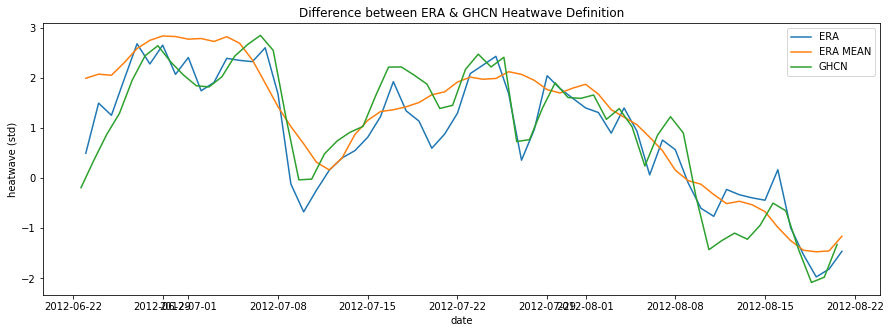

In [158]:
plot_year = 2012
plt.rcParams['figure.figsize'] = [15, 5]
plt.title("Difference between ERA & GHCN Heatwave Definition")
plt.plot(load_heatwave_data()[str(plot_year)], label="ERA")
plt.plot(load_heatwave_data("mean")[str(plot_year)], label="ERA MEAN")
plt.plot(load_heatwave_data("ghcn")[str(plot_year)], label="GHCN")
plt.xlabel("date")
plt.ylabel("heatwave (std)")
plt.legend()
plt.show()

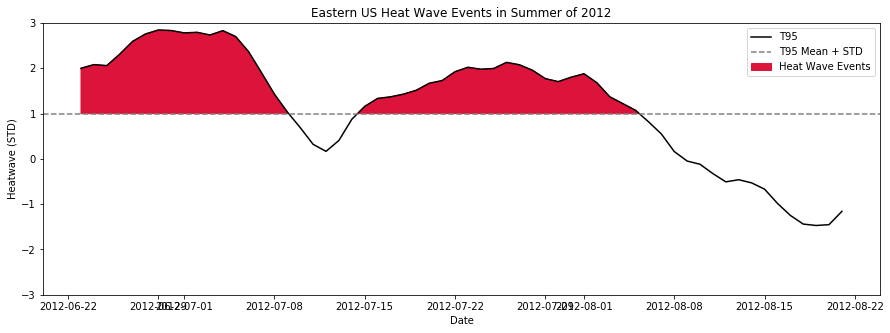

In [143]:
# Load Heatwave Data
heatwave = load_heatwave_data("mean")

# Heatwave Threshold (Heatwave.mean + Heatwave.std = 1 (for normalized data))
heatwave_threshold = 1

YEARS = np.unique(heatwave.index.year)

plot_heatwave(heatwave['series'], 2012)

In [186]:
# Feature Generation and Machine Learning Training

def create_features(heatwave: pd.DataFrame, precursor: pd.DataFrame, lag: int):
    features = pd.DataFrame(index=heatwave.index)
    
    # Heatwave Timestamp minus 'lag' Days
    index = (heatwave.index - pd.Timedelta(lag, 'D'))
    
#     # Pacific North America Pattern Index
#     features["pna"] = load_pna_data().loc[index].values
    
#     # North Atlantic Oscilation Index
#     features["nao"] = load_nao_data().loc[index].values
    
#     # El Nino Southern Oscilation Index
#     enso = load_enso_data()
#     for column in enso.columns:
#         features[column] = enso[column][index].values
    
    # Sea Surface Temperature Patterns (Sem)
    for column in precursor.columns:
        if 'average' in column:
            features[column] = precursor[column][index].values
            features[f"{column}-halfweekly"] = precursor[column].rolling(4).mean()[index].values
#             features[f"{column}-weekly"] = precursor[column].rolling(7).mean()[index].values
        
    return features

def train_test_split(features: pd.DataFrame, labels: pd.DataFrame, test_year: int):
    
    # Split Features and Labels based on Test Year
    train_x = pd.concat([features[str(year)] for year in YEARS if year != test_year])
    test_x = features[str(test_year)]

    train_y = pd.concat([labels[str(year)] for year in YEARS if year != test_year])
    test_y = labels[str(test_year)]

    # Balance Dataset
    pos = np.where(train_y > heatwave_threshold)[0]
    neg = np.where(train_y < heatwave_threshold)[0]
    
    # Create 75/25 NEG/POS Selection, Balancing Data Imbalance and Data Amount
    idx = np.random.permutation(np.concatenate([pos, np.random.choice(neg, 3*len(pos), False)]))
    
    return train_x.iloc[idx], train_y.iloc[idx], test_x, test_y
    
def train(regressor, features: pd.DataFrame, labels: pd.DataFrame, test_year: int):
    
    train_x, train_y, test_x, test_y = train_test_split(features, labels, test_year)
    
    # Fit Regressor to Data
    regressor.fit(train_x, train_y.values.ravel())
    
    # Predict Heatwaves for Test Year
    prediction = pd.DataFrame(regressor.predict(test_x).reshape(-1, 1), index=test_y.index)
    
    return test_y, prediction

def train_year(regressor, heatwave: pd.DataFrame, precursor_lag: int, lag: int, test_year: int):
    
    # Load Precursor Data for Specific Lag and Test Year
    precursor = load_sst_precursor_data(test_year, precursor_lag)
    
    # Transform Precursor Data into Features
    features = create_features(heatwave, precursor, lag)
    
    # Train Regressor with Features and Heatwave Data
    test_y, prediction = train(regressor, features, heatwave, test_year)
    
    return prediction

def train_all(regressor, heatwave: pd.DataFrame, precursor_lag: int, lag: int):
    
    # Train for each Test Year (In Parallel)
    with ProcessPoolExecutor(4) as ex:
        
        # Run Train Year Function for Each Year in Parallel
        futures = [ex.submit(train_year, regressor, heatwave, precursor_lag, lag, test_year) for test_year in YEARS]
        
        # Obtain Results
        results = [future.result() for future in futures]
        
        # Wrap into Predictions DataFrame
        predictions = pd.DataFrame(np.concatenate(results), index=heatwave.index)
        
    return predictions

def train_optimize(heatwave: pd.DataFrame, heatwave_threshold: float, precursor_lag: int, lag: int, iterations: int):
    hyperparameter_space = [
        Integer(100, 250, name="n_estimators"),
        Integer(2, 6, name="max_depth"),
        Real(1E-3, 0.1, name="learning_rate")]
    
    def _train_optimize_callback(result):
        print(f"{len(result.x_iters):3d}: {-result.func_vals[-1]:5.5f} <- {str(result.x_iters[-1]):30} | max: {-result.fun:5.5f} <- {str(result.x):30}")
    
    @use_named_args(hyperparameter_space)
    def _train_optimize(**kwargs):
        n_estimators = kwargs['n_estimators']
        max_depth = kwargs['max_depth']
        learning_rate = kwargs['learning_rate']
        
        regressor = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
        predictions = train_all(regressor, heatwave, precursor_lag, lag)
        score = roc_auc_score(heatwave > heatwave_threshold, predictions)
        
        return -score
    
    result = gp_minimize(_train_optimize, hyperparameter_space, n_calls=iterations, callback=_train_optimize_callback)
    
    return {item.name: value for item, value in zip(hyperparameter_space, result.x)}

def feature_importances(regressor, heatwave, precursor_lag, lag, test_year):
    
    # Load Precursor Data for Specific Lag and Test Year
    precursor = load_sst_precursor_data(test_year, precursor_lag)
    
    # Transform Precursor Data into Features
    features = create_features(heatwave, precursor, lag)
    
    # Train Regressor with Features and Heatwave Data
    test_y, prediction = train(regressor, features, heatwave, test_year)
    
    order = np.argsort(regressor.feature_importances_)
    
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.title(f"Feature Importances for {regressor.__class__.__name__} @ test year {test_year}")
    plt.barh(np.arange(len(features.columns)), regressor.feature_importances_[order], tick_label=features.columns[order])
    plt.show()
    
def train_deviance_year(regressor, labels, precursor_lag, lag, test_year):
    # Load Precursor Data for Specific Lag and Test Year
    precursor = load_sst_precursor_data(test_year, precursor_lag)

    # Transform Precursor Data into Features
    features = create_features(labels, precursor, lag)

    train_x, train_y, test_x, test_y = train_test_split(features, labels, test_year)

    # Fit Regressor to Data
    regressor.fit(train_x, train_y.values.ravel())
    
    # Return Train Score & Test Score (MSE)
    return regressor.train_score_, [mean_squared_error(p, test_y) for p in regressor.staged_predict(test_x)]
    
def train_deviance(regressor, heatwave, precursor_lag, lag, plot=True):
    # Train for each Test Year (In Parallel)
    with ProcessPoolExecutor(4) as ex:
        
        # Run Train Year Function for Each Year in Parallel
        futures = [ex.submit(train_deviance_year, regressor, heatwave, precursor_lag, lag, test_year) for test_year in YEARS]
        
        train_scores = []
        test_scores = []
        
        # Obtain Results
        for train_mse, test_mse in [future.result() for future in futures]:
            train_scores.append(train_mse)
            test_scores.append(test_mse)
            
    train_scores = np.mean(train_scores, 0)
    test_scores = np.mean(test_scores, 0)
    
    opt_iterations = np.argmin(test_scores) + 1
    opt_score = np.min(test_scores)
    
    if plot:
        plt.rcParams['figure.figsize'] = [10, 5]
        plt.title(f"Gradient Boosting Regressor Performance over Iterations\n(Optimal Iterations: {opt_iterations}, Min MSE: {opt_score})")
        plt.plot(train_scores, label="Training Set Deviance")
        plt.plot(test_scores, label="Test Set Deviance")
        plt.xlabel("Boosting Iterations")
        plt.ylabel("Deviance (MSE)")
        plt.legend()
        plt.show()
    
    return opt_iterations, opt_score

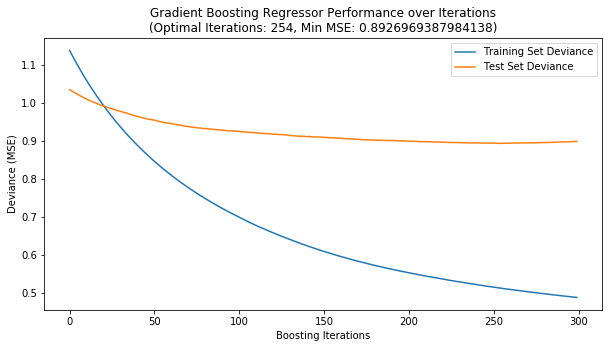

GradientBoosting(n_estimators=254, learning_rate=0.01) -> 0.8926969387984138
[  0, 10] AUC 0.68321 +/- 0.00734

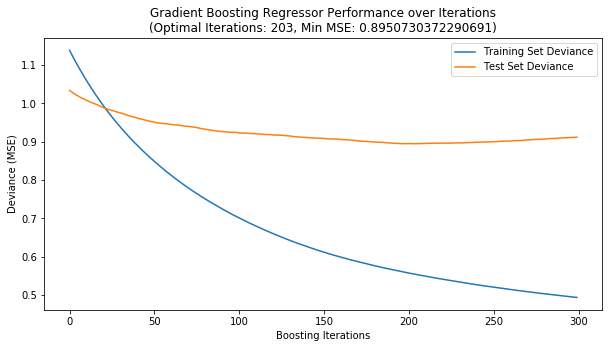

GradientBoosting(n_estimators=203, learning_rate=0.01) -> 0.8950730372290691
[  1, 10] AUC 0.67852 +/- 0.00136

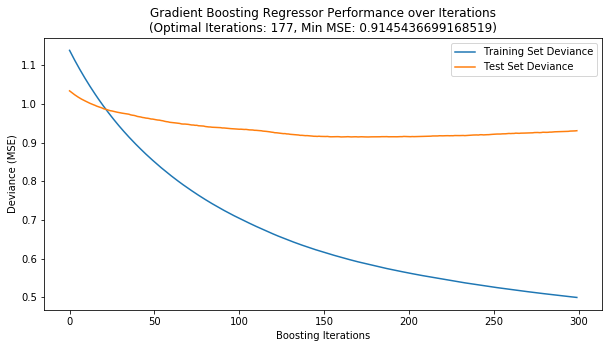

GradientBoosting(n_estimators=177, learning_rate=0.01) -> 0.9145436699168519
[  2, 10] AUC 0.67715 +/- 0.00421

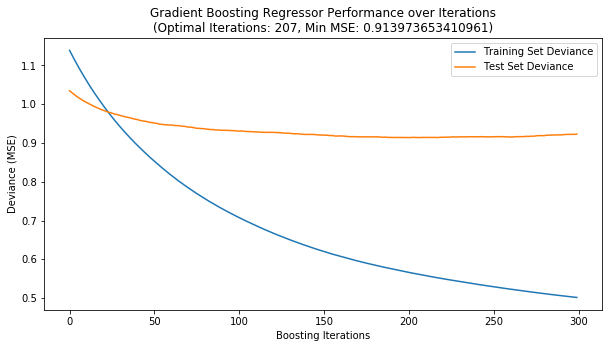

GradientBoosting(n_estimators=207, learning_rate=0.01) -> 0.913973653410961
[  3, 10] AUC 0.67341 +/- 0.00276

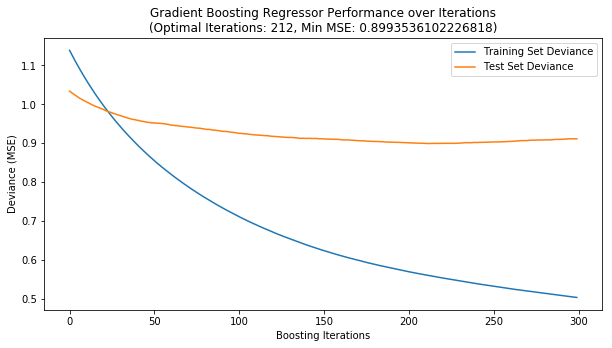

GradientBoosting(n_estimators=212, learning_rate=0.01) -> 0.8993536102226818
[  4, 10] AUC 0.65654 +/- 0.00185

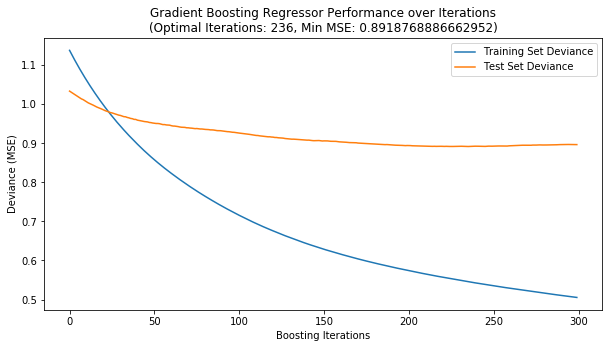

GradientBoosting(n_estimators=236, learning_rate=0.01) -> 0.8918768886662952
[  5, 10] AUC 0.65483 +/- 0.01041

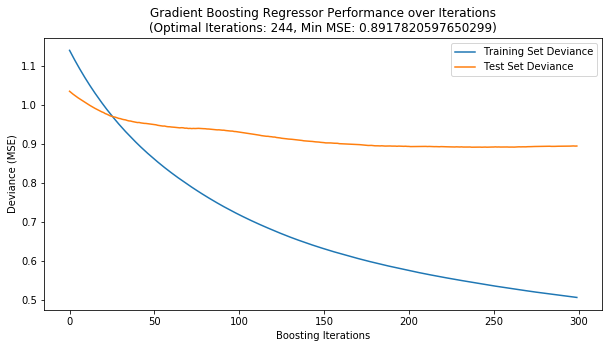

GradientBoosting(n_estimators=244, learning_rate=0.01) -> 0.8917820597650299
[  6, 10] AUC 0.66995 +/- 0.00187

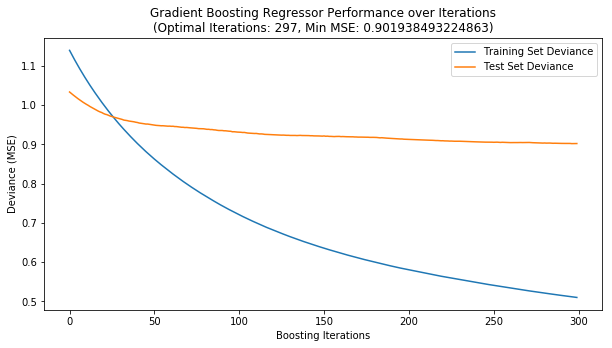

GradientBoosting(n_estimators=297, learning_rate=0.01) -> 0.901938493224863
[  7, 10] AUC 0.66327 +/- 0.00391

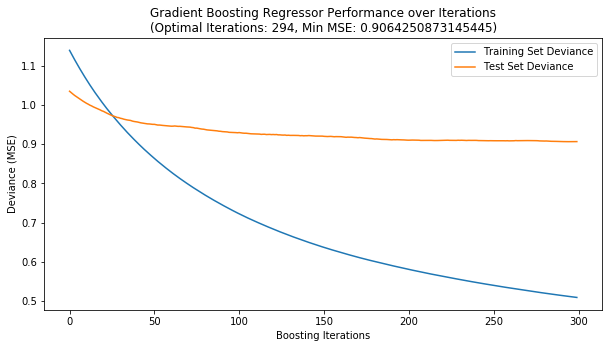

GradientBoosting(n_estimators=294, learning_rate=0.01) -> 0.9064250873145445
[  8, 10] AUC 0.66450 +/- 0.00325

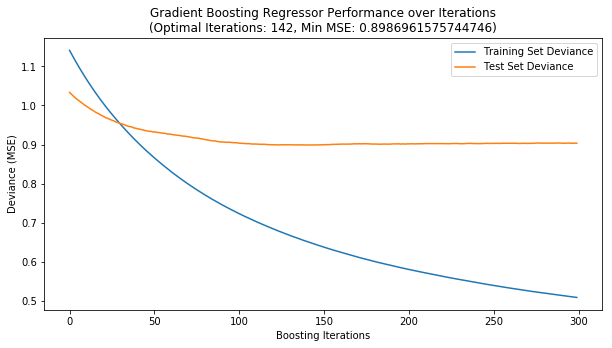

GradientBoosting(n_estimators=142, learning_rate=0.01) -> 0.8986961575744746
[  9, 10] AUC 0.66855 +/- 0.00337

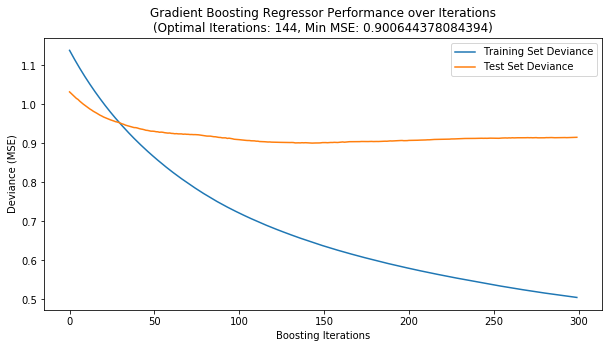

GradientBoosting(n_estimators=144, learning_rate=0.01) -> 0.900644378084394
[ 10, 10] AUC 0.67280 +/- 0.00237

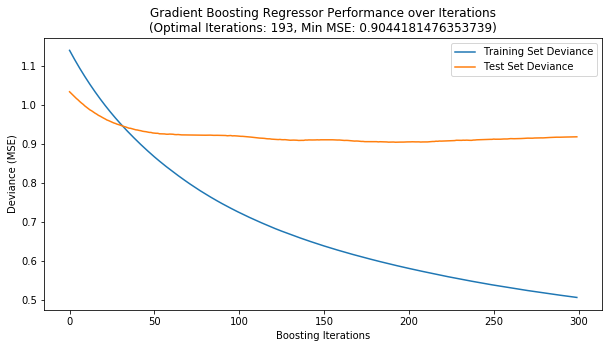

GradientBoosting(n_estimators=193, learning_rate=0.01) -> 0.9044181476353739
[ 11, 10] AUC 0.67477 +/- 0.00118

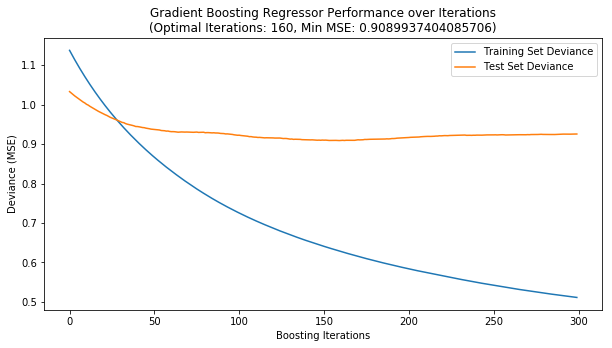

GradientBoosting(n_estimators=160, learning_rate=0.01) -> 0.9089937404085706
[ 12, 10] AUC 0.66553 +/- 0.00260

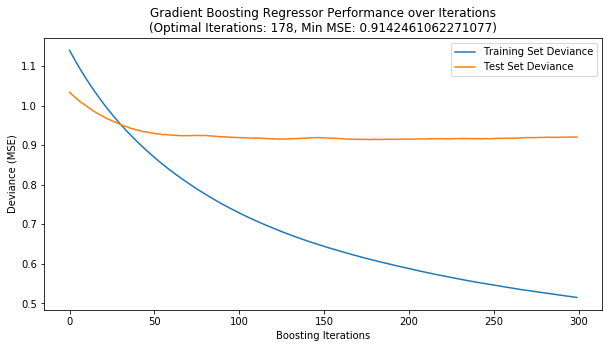

GradientBoosting(n_estimators=178, learning_rate=0.01) -> 0.9142461062271077
[ 13, 10] AUC 0.66177 +/- 0.00135

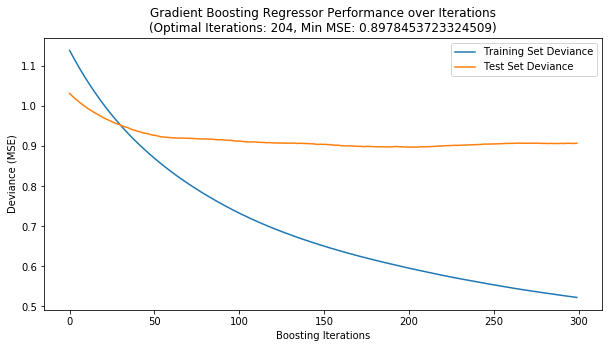

GradientBoosting(n_estimators=204, learning_rate=0.01) -> 0.8978453723324509
[ 14, 10] AUC 0.68121 +/- 0.00232

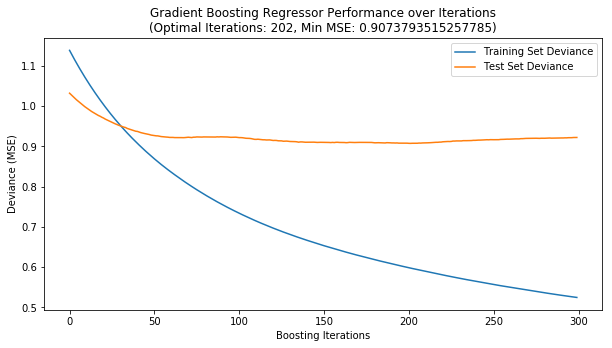

GradientBoosting(n_estimators=202, learning_rate=0.01) -> 0.9073793515257785
[ 15, 10] AUC 0.66977 +/- 0.00194

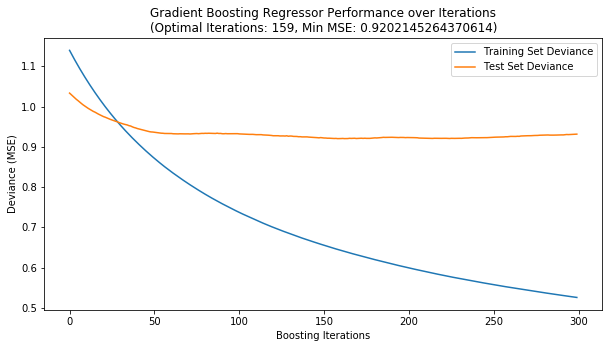

GradientBoosting(n_estimators=159, learning_rate=0.01) -> 0.9202145264370614
[ 16, 10] AUC 0.66192 +/- 0.00292

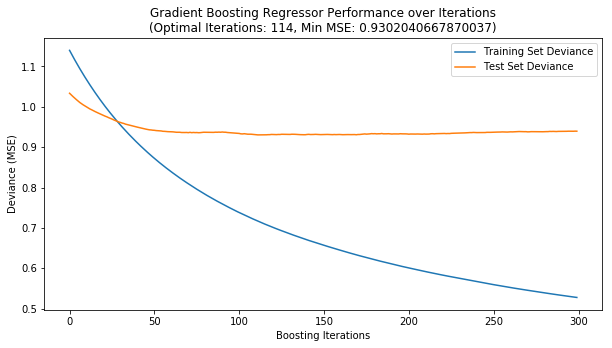

GradientBoosting(n_estimators=114, learning_rate=0.01) -> 0.9302040667870037
[ 17, 10] AUC 0.64213 +/- 0.00237

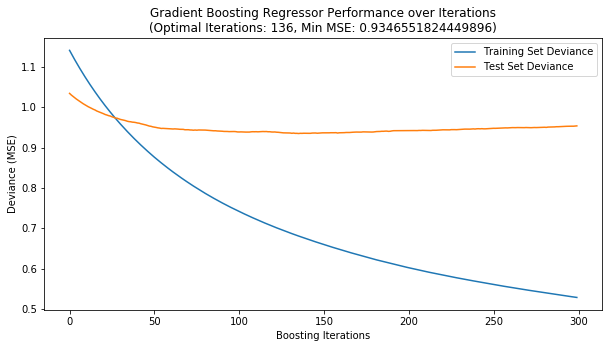

GradientBoosting(n_estimators=136, learning_rate=0.01) -> 0.9346551824449896
[ 18, 10] AUC 0.64540 +/- 0.00258

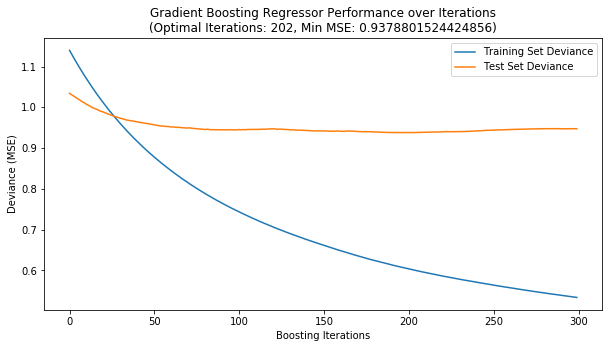

GradientBoosting(n_estimators=202, learning_rate=0.01) -> 0.9378801524424856
[ 19, 10] AUC 0.67134 +/- 0.00178

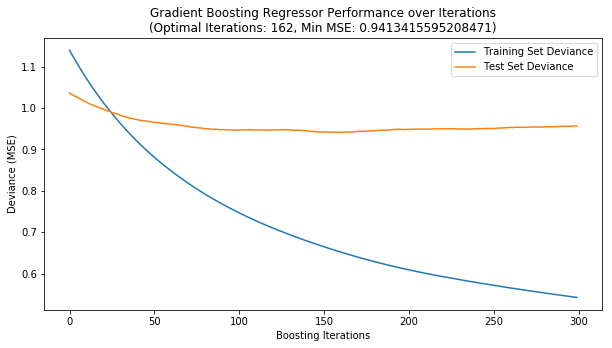

GradientBoosting(n_estimators=162, learning_rate=0.01) -> 0.9413415595208471
[ 20, 10] AUC 0.65116 +/- 0.00148

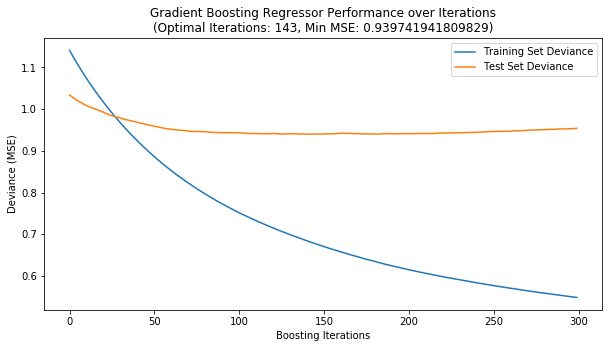

GradientBoosting(n_estimators=143, learning_rate=0.01) -> 0.939741941809829
[ 21, 10] AUC 0.65844 +/- 0.00216

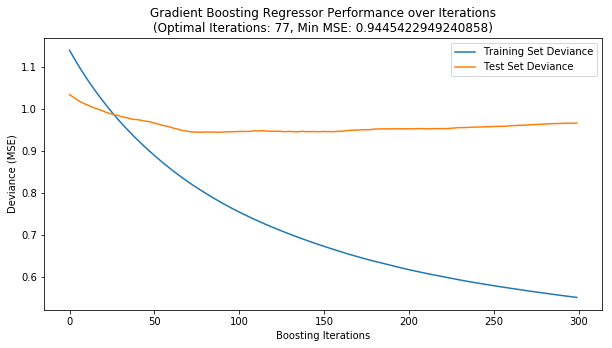

GradientBoosting(n_estimators=77, learning_rate=0.01) -> 0.9445422949240858
[ 22, 10] AUC 0.65270 +/- 0.00452

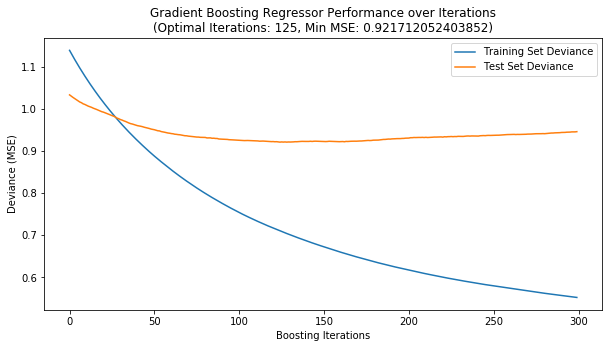

GradientBoosting(n_estimators=125, learning_rate=0.01) -> 0.921712052403852
[ 23, 10] AUC 0.65995 +/- 0.00402

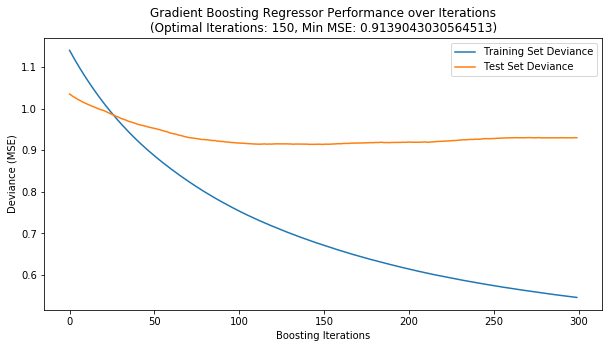

GradientBoosting(n_estimators=150, learning_rate=0.01) -> 0.9139043030564513
[ 24, 10] AUC 0.67723 +/- 0.00285

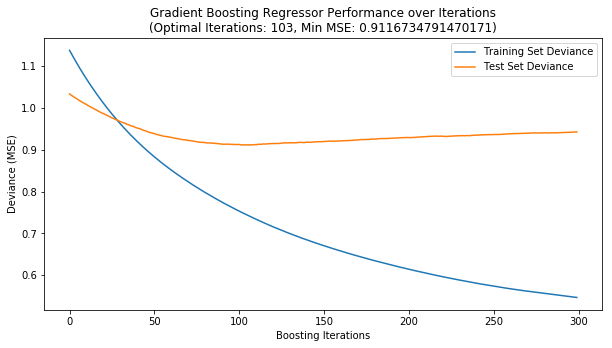

GradientBoosting(n_estimators=103, learning_rate=0.01) -> 0.9116734791470171
[ 25, 10] AUC 0.67650 +/- 0.00506

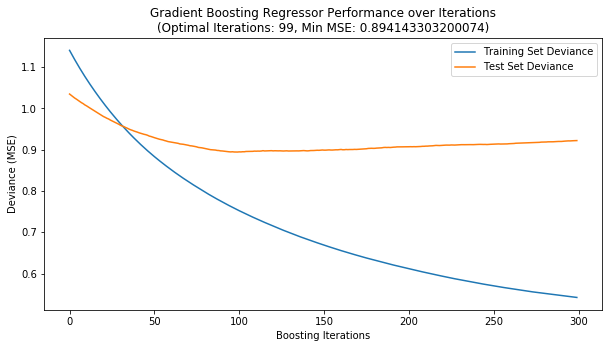

GradientBoosting(n_estimators=99, learning_rate=0.01) -> 0.894143303200074
[ 26, 10] AUC 0.67424 +/- 0.00219

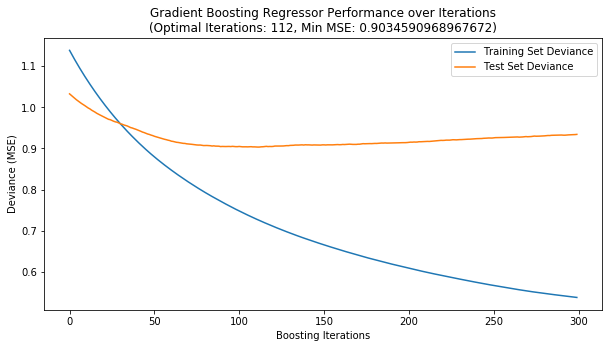

GradientBoosting(n_estimators=112, learning_rate=0.01) -> 0.9034590968967672
[ 27, 10] AUC 0.68493 +/- 0.00448

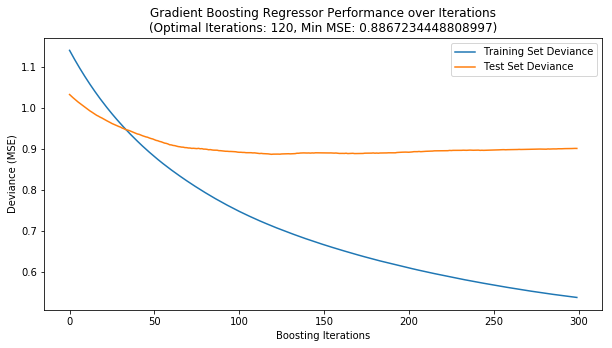

GradientBoosting(n_estimators=120, learning_rate=0.01) -> 0.8867234448808997
[ 28, 10] AUC 0.67622 +/- 0.00357

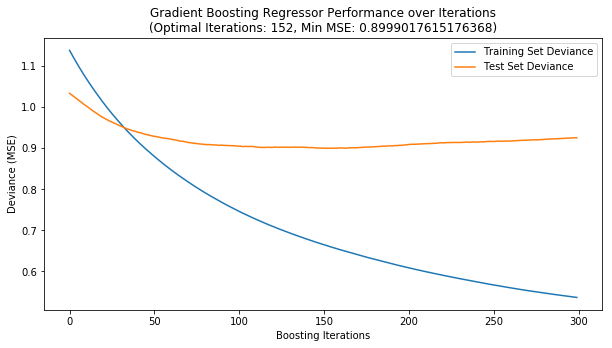

GradientBoosting(n_estimators=152, learning_rate=0.01) -> 0.8999017615176368
[ 29, 10] AUC 0.68435 +/- 0.00246

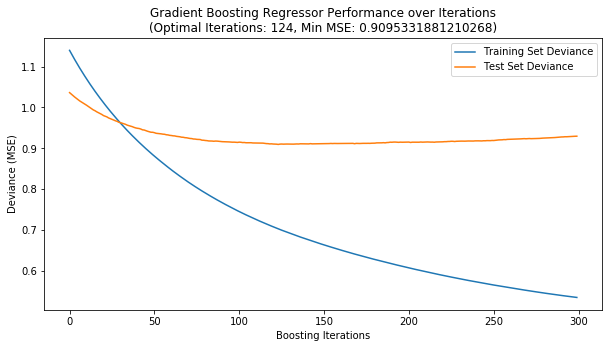

GradientBoosting(n_estimators=124, learning_rate=0.01) -> 0.9095331881210268
[ 30, 10] AUC 0.67561 +/- 0.00193

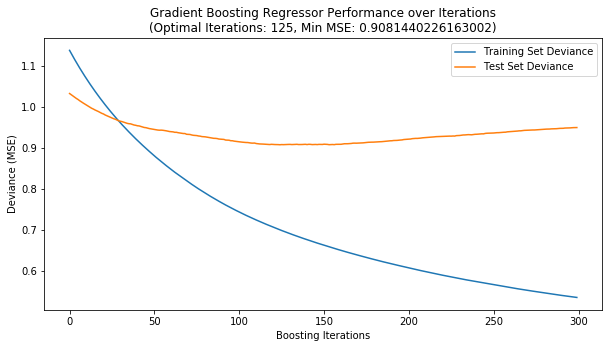

GradientBoosting(n_estimators=125, learning_rate=0.01) -> 0.9081440226163002
[ 31, 10] AUC 0.68820 +/- 0.00289

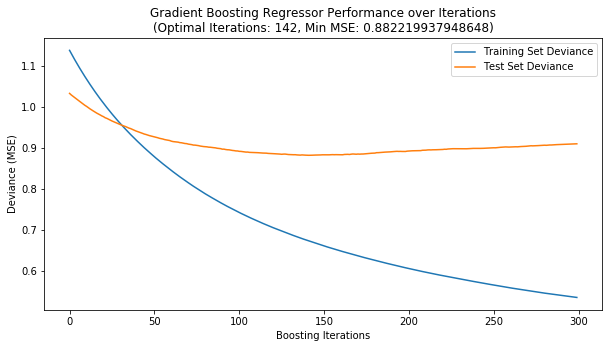

GradientBoosting(n_estimators=142, learning_rate=0.01) -> 0.882219937948648
[ 32, 10] AUC 0.69768 +/- 0.00317

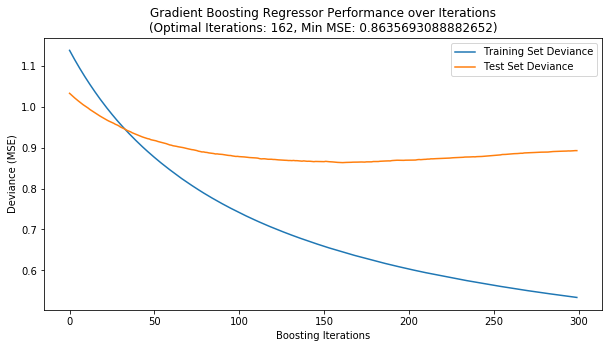

GradientBoosting(n_estimators=162, learning_rate=0.01) -> 0.8635693088882652
[ 33, 10] AUC 0.72243 +/- 0.00489

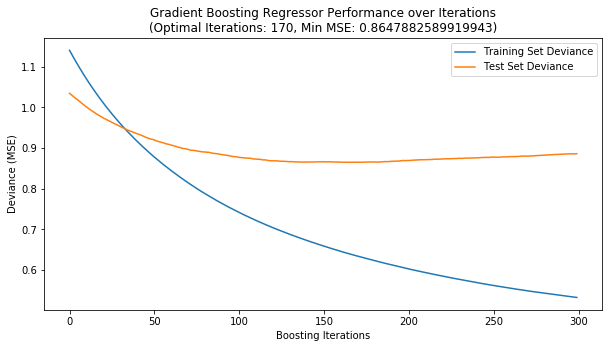

GradientBoosting(n_estimators=170, learning_rate=0.01) -> 0.8647882589919943
[ 34, 10] AUC 0.71101 +/- 0.00178

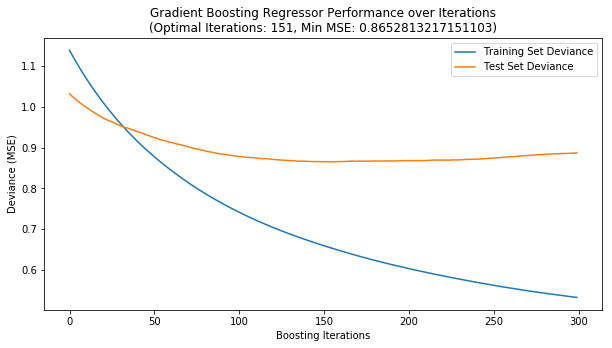

GradientBoosting(n_estimators=151, learning_rate=0.01) -> 0.8652813217151103
[ 35, 10] AUC 0.70443 +/- 0.00352

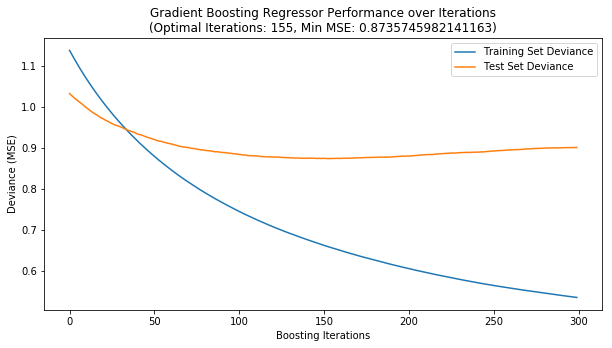

GradientBoosting(n_estimators=155, learning_rate=0.01) -> 0.8735745982141163
[ 36, 10] AUC 0.69423 +/- 0.00275

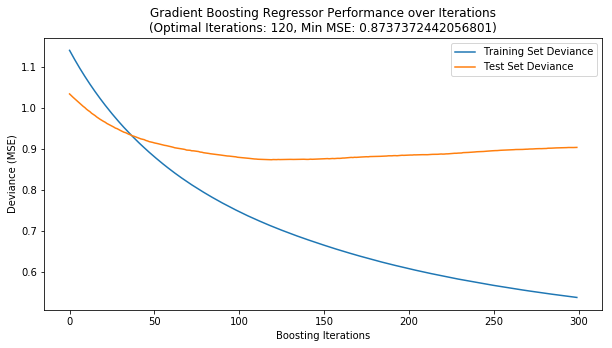

GradientBoosting(n_estimators=120, learning_rate=0.01) -> 0.8737372442056801
[ 37, 10] AUC 0.69333 +/- 0.00191

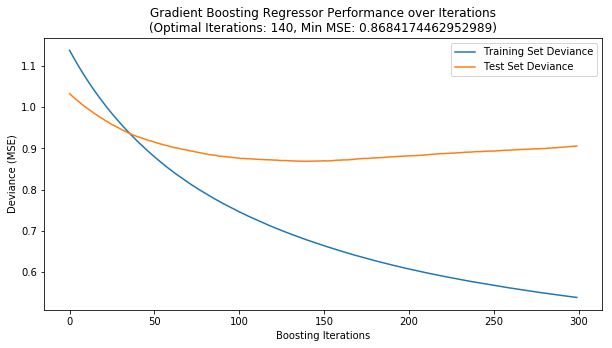

GradientBoosting(n_estimators=140, learning_rate=0.01) -> 0.8684174462952989
[ 38, 10] AUC 0.69340 +/- 0.00248

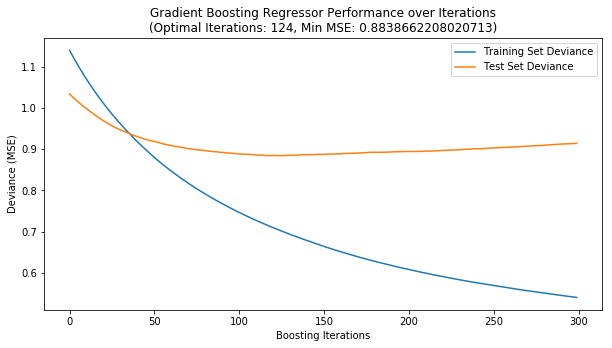

GradientBoosting(n_estimators=124, learning_rate=0.01) -> 0.8838662208020713
[ 39, 10] AUC 0.69769 +/- 0.00180

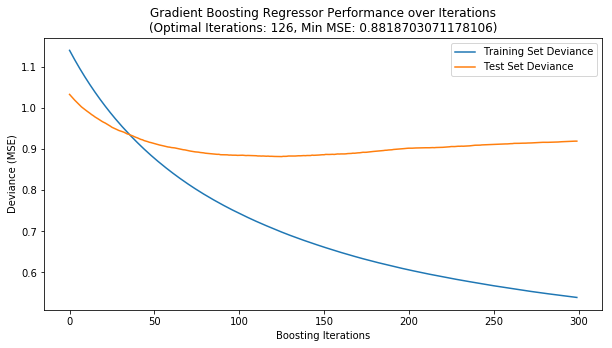

GradientBoosting(n_estimators=126, learning_rate=0.01) -> 0.8818703071178106
[ 40, 10] AUC 0.69761 +/- 0.00204

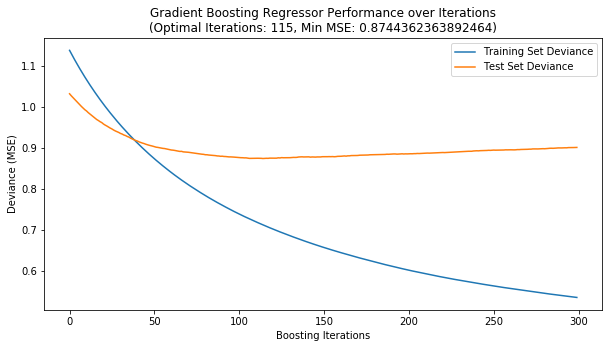

GradientBoosting(n_estimators=115, learning_rate=0.01) -> 0.8744362363892464
[ 41, 10] AUC 0.70281 +/- 0.00532

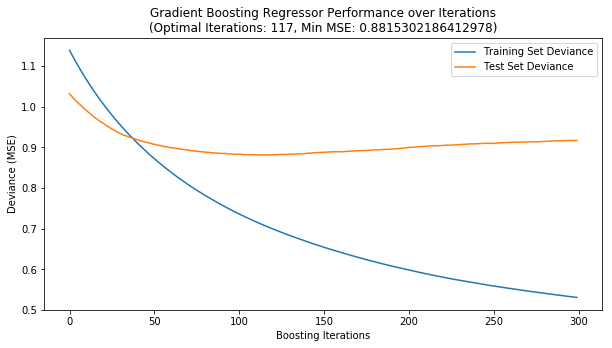

GradientBoosting(n_estimators=117, learning_rate=0.01) -> 0.8815302186412978
[ 42, 10] AUC 0.70667 +/- 0.00321

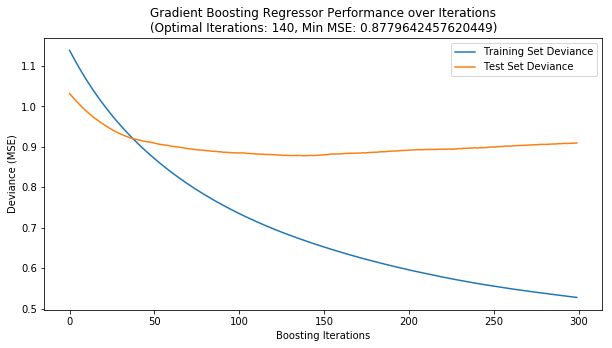

GradientBoosting(n_estimators=140, learning_rate=0.01) -> 0.8779642457620449
[ 43, 10] AUC 0.71307 +/- 0.00296

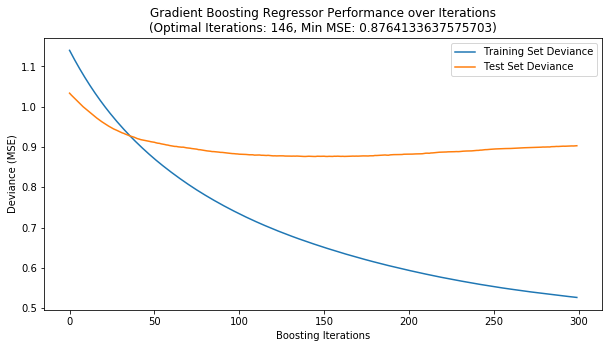

GradientBoosting(n_estimators=146, learning_rate=0.01) -> 0.8764133637575703
[ 44, 10] AUC 0.70850 +/- 0.00190

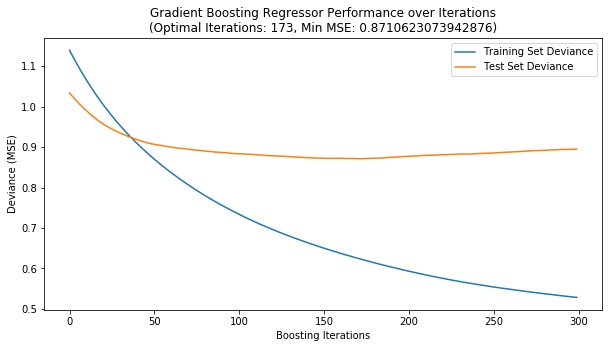

GradientBoosting(n_estimators=173, learning_rate=0.01) -> 0.8710623073942876
[ 45, 10] AUC 0.70852 +/- 0.00203

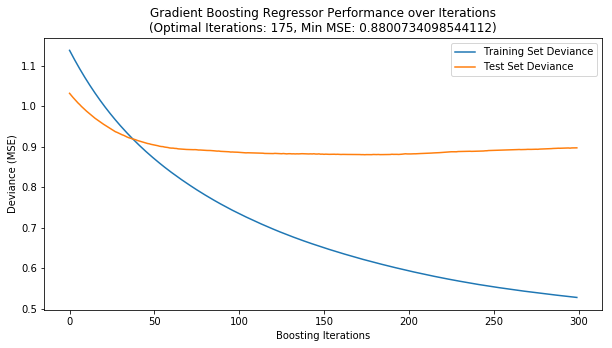

GradientBoosting(n_estimators=175, learning_rate=0.01) -> 0.8800734098544112
[ 46, 10] AUC 0.71600 +/- 0.00246

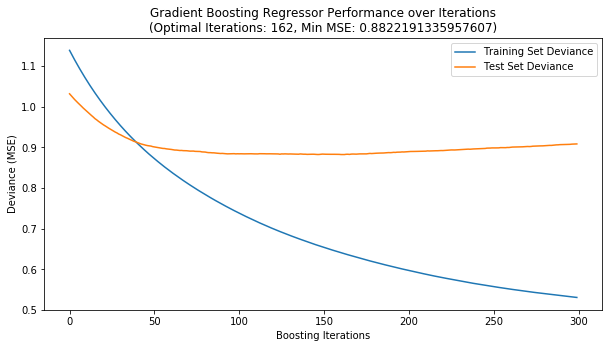

GradientBoosting(n_estimators=162, learning_rate=0.01) -> 0.8822191335957607
[ 47, 10] AUC 0.72487 +/- 0.00172

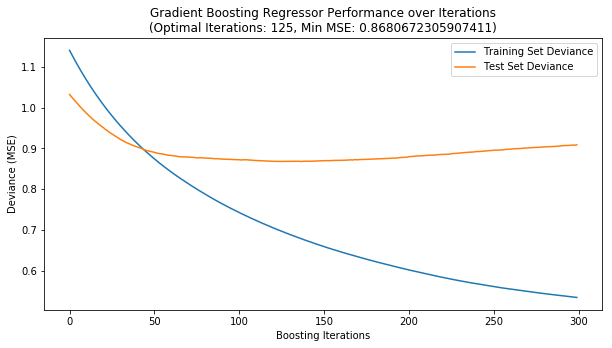

GradientBoosting(n_estimators=125, learning_rate=0.01) -> 0.8680672305907411
[ 48, 10] AUC 0.71799 +/- 0.00198

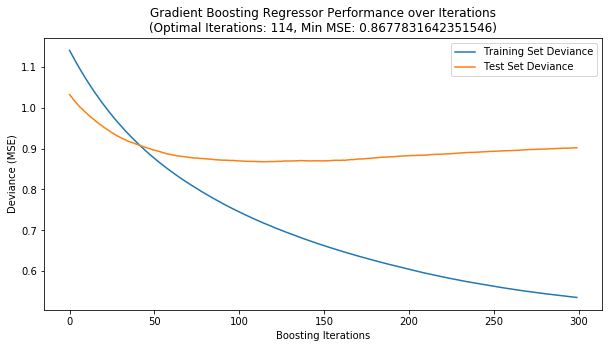

GradientBoosting(n_estimators=114, learning_rate=0.01) -> 0.8677831642351546
[ 49, 10] AUC 0.70959 +/- 0.00232

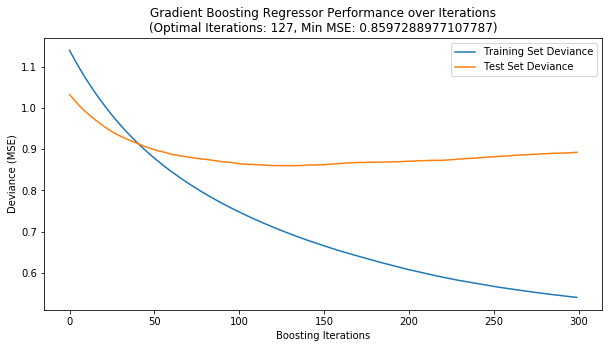

GradientBoosting(n_estimators=127, learning_rate=0.01) -> 0.8597288977107787
[ 50, 10] AUC 0.71040 +/- 0.00505

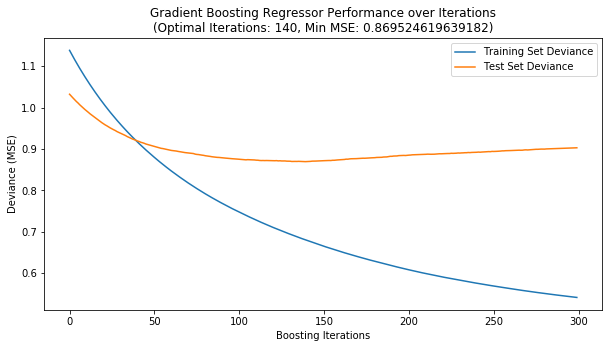

GradientBoosting(n_estimators=140, learning_rate=0.01) -> 0.869524619639182
[ 51, 10] AUC 0.71377 +/- 0.00195

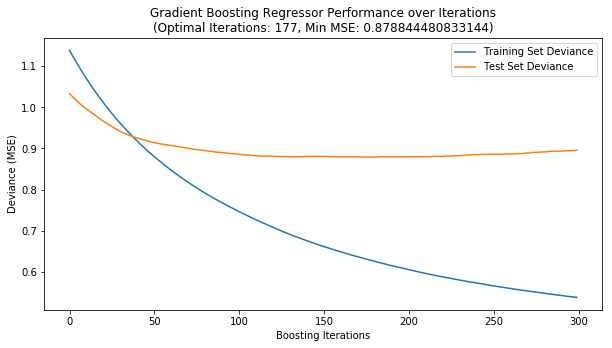

GradientBoosting(n_estimators=177, learning_rate=0.01) -> 0.878844480833144
[ 52, 10] AUC 0.71067 +/- 0.00285

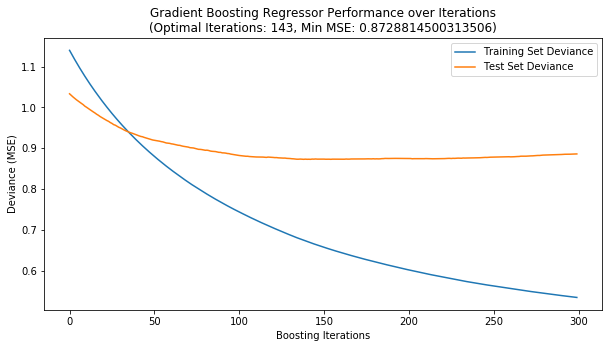

GradientBoosting(n_estimators=143, learning_rate=0.01) -> 0.8728814500313506
[ 53, 10] AUC 0.70345 +/- 0.00233

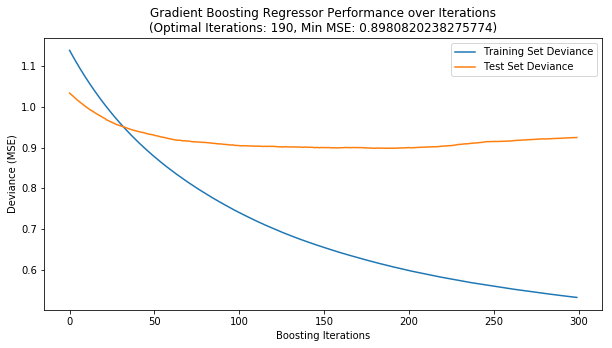

GradientBoosting(n_estimators=190, learning_rate=0.01) -> 0.8980820238275774
[ 54, 10] AUC 0.69302 +/- 0.00461

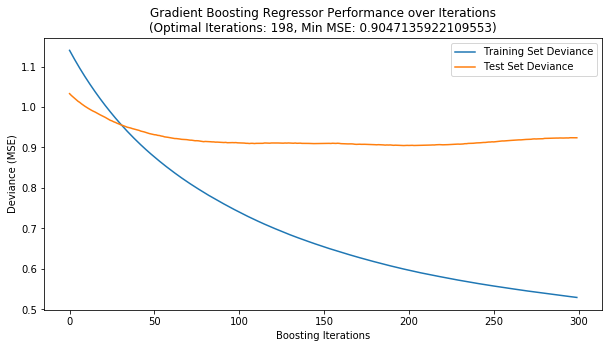

GradientBoosting(n_estimators=198, learning_rate=0.01) -> 0.9047135922109553
[ 55, 10] AUC 0.68330 +/- 0.00394

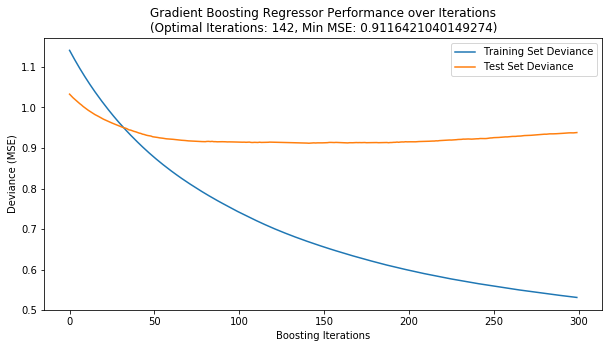

GradientBoosting(n_estimators=142, learning_rate=0.01) -> 0.9116421040149274
[ 56, 10] AUC 0.67203 +/- 0.00520

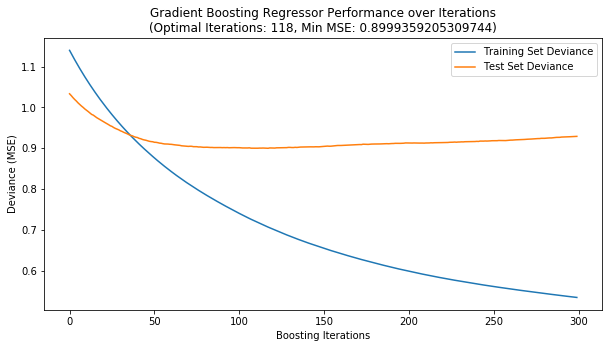

GradientBoosting(n_estimators=118, learning_rate=0.01) -> 0.8999359205309744
[ 57, 10] AUC 0.67866 +/- 0.00654

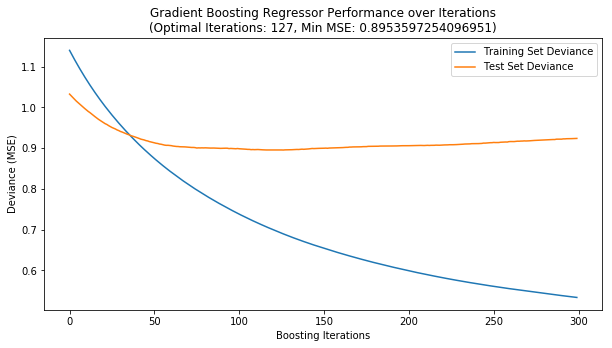

GradientBoosting(n_estimators=127, learning_rate=0.01) -> 0.8953597254096951
[ 58, 10] AUC 0.67915 +/- 0.00530

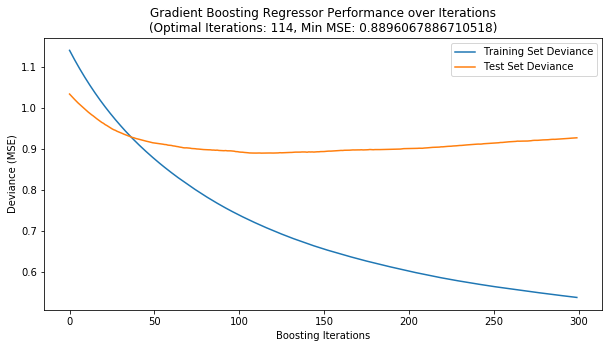

GradientBoosting(n_estimators=114, learning_rate=0.01) -> 0.8896067886710518
[ 59, 10] AUC 0.67701 +/- 0.00293

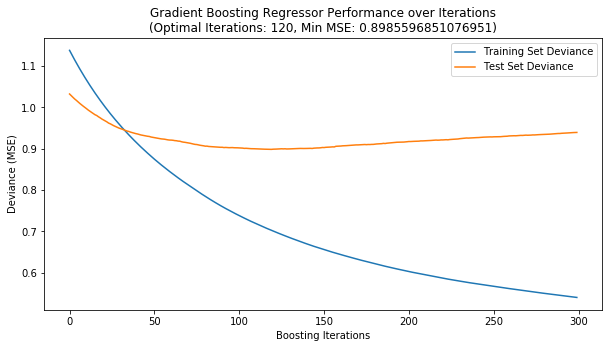

GradientBoosting(n_estimators=120, learning_rate=0.01) -> 0.8985596851076951
[ 60, 10] AUC 0.67392 +/- 0.00148

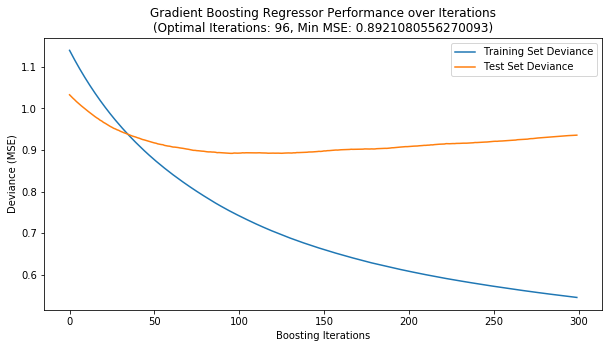

GradientBoosting(n_estimators=96, learning_rate=0.01) -> 0.8921080556270093
[ 61, 10] AUC 0.66256 +/- 0.00325

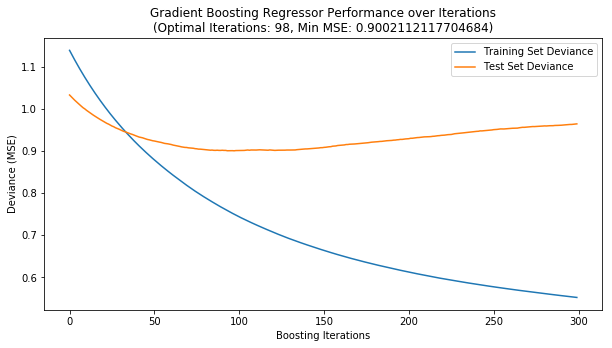

GradientBoosting(n_estimators=98, learning_rate=0.01) -> 0.9002112117704684
[ 62, 10] AUC 0.65211 +/- 0.00304

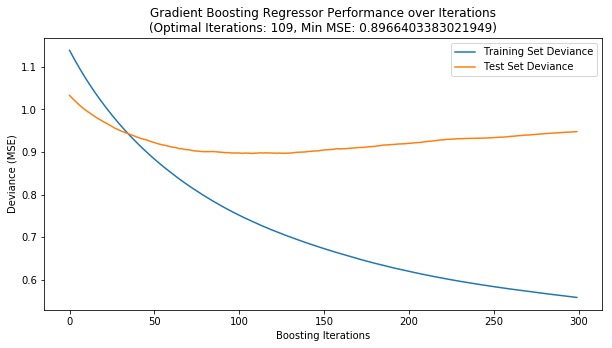

GradientBoosting(n_estimators=109, learning_rate=0.01) -> 0.8966403383021949
[ 63, 10] AUC 0.65673 +/- 0.00347

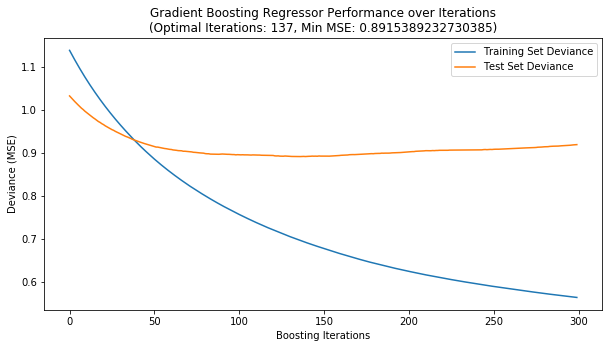

GradientBoosting(n_estimators=137, learning_rate=0.01) -> 0.8915389232730385
[ 64, 10] AUC 0.65832 +/- 0.00276

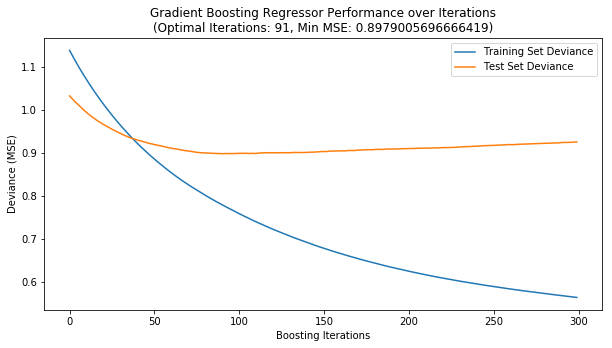

GradientBoosting(n_estimators=91, learning_rate=0.01) -> 0.8979005696666419
[ 65, 10] AUC 0.66766 +/- 0.00345

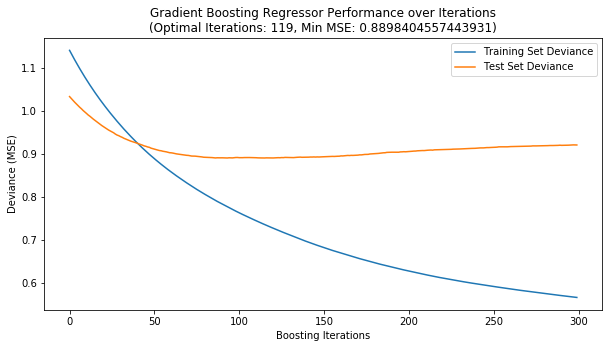

GradientBoosting(n_estimators=119, learning_rate=0.01) -> 0.8898404557443931
[ 66, 10] AUC 0.67239 +/- 0.00265

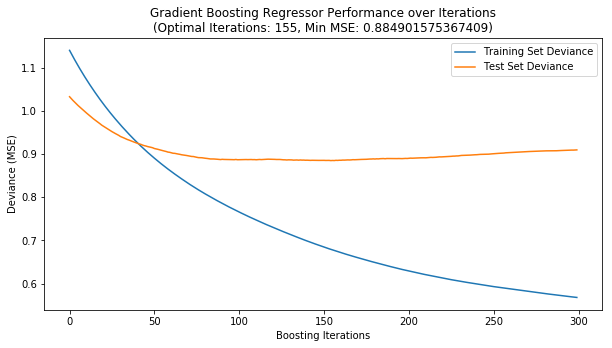

GradientBoosting(n_estimators=155, learning_rate=0.01) -> 0.884901575367409
[ 67, 10] AUC 0.67194 +/- 0.00161

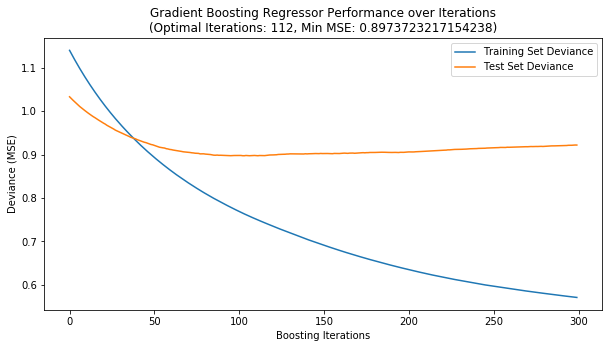

GradientBoosting(n_estimators=112, learning_rate=0.01) -> 0.8973723217154238
[ 68, 10] AUC 0.67356 +/- 0.00279

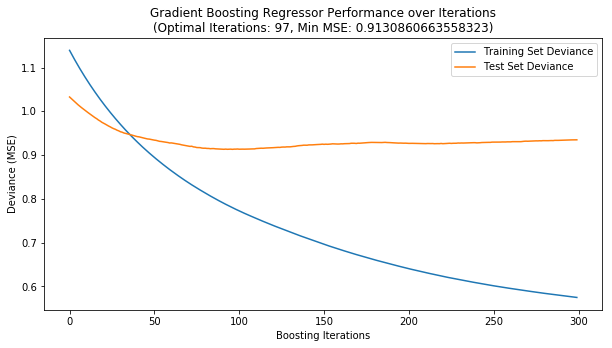

GradientBoosting(n_estimators=97, learning_rate=0.01) -> 0.9130860663558323
[ 69, 10] AUC 0.67111 +/- 0.00589

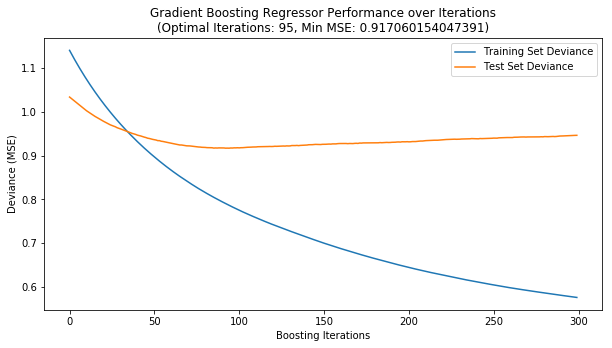

GradientBoosting(n_estimators=95, learning_rate=0.01) -> 0.917060154047391
[ 70, 10] AUC 0.67294 +/- 0.00476

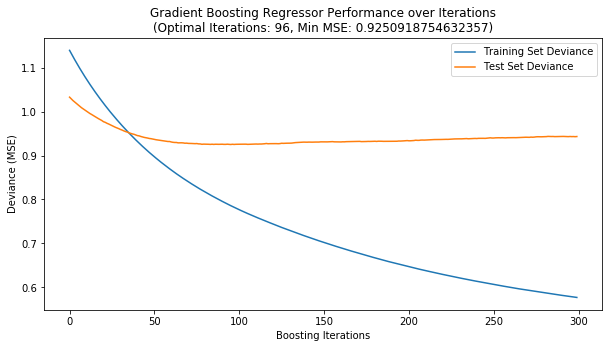

GradientBoosting(n_estimators=96, learning_rate=0.01) -> 0.9250918754632357
[ 71, 10] AUC 0.67424 +/- 0.00206

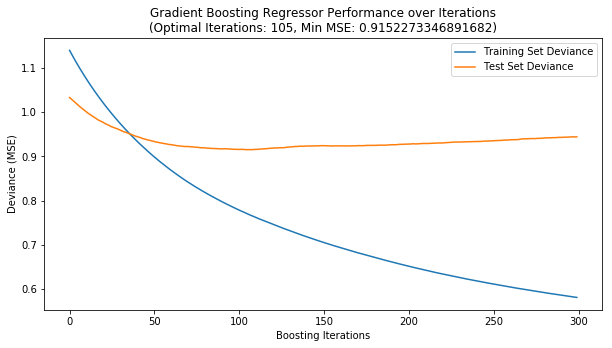

GradientBoosting(n_estimators=105, learning_rate=0.01) -> 0.9152273346891682
[ 72, 10] AUC 0.67924 +/- 0.00228

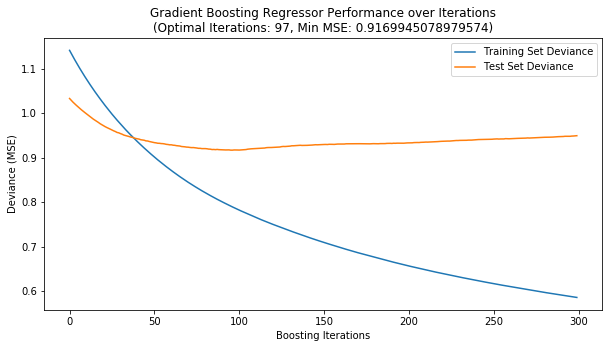

GradientBoosting(n_estimators=97, learning_rate=0.01) -> 0.9169945078979574
[ 73, 10] AUC 0.67770 +/- 0.00332

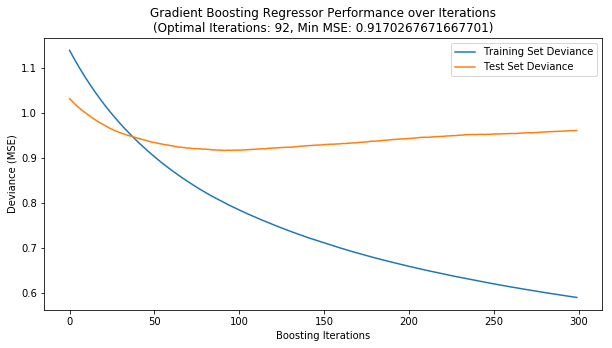

GradientBoosting(n_estimators=92, learning_rate=0.01) -> 0.9170267671667701
[ 74, 10] AUC 0.67668 +/- 0.00182

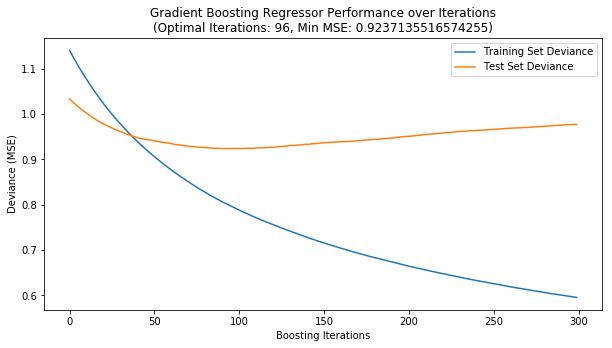

GradientBoosting(n_estimators=96, learning_rate=0.01) -> 0.9237135516574255
[ 75, 10] AUC 0.67572 +/- 0.00396

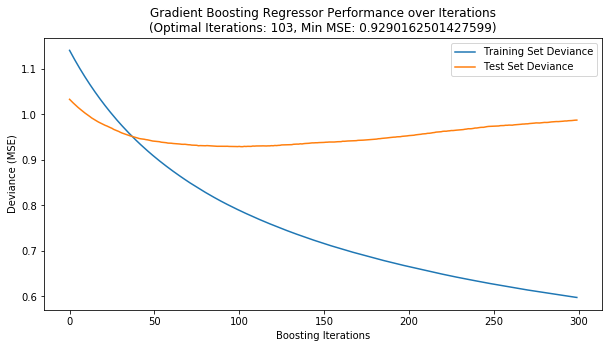

GradientBoosting(n_estimators=103, learning_rate=0.01) -> 0.9290162501427599
[ 76, 10] AUC 0.67529 +/- 0.00310

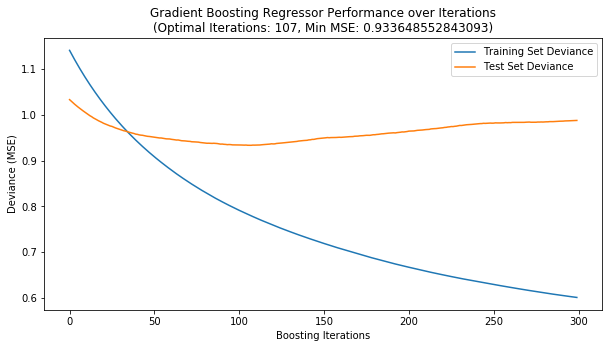

GradientBoosting(n_estimators=107, learning_rate=0.01) -> 0.933648552843093
[ 77, 10] AUC 0.66578 +/- 0.00214

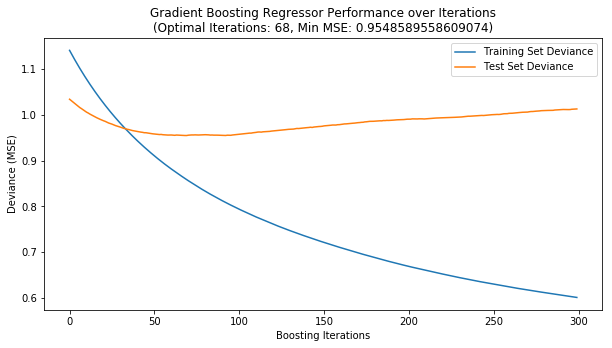

GradientBoosting(n_estimators=68, learning_rate=0.01) -> 0.9548589558609074
[ 78, 10] AUC 0.65109 +/- 0.00271

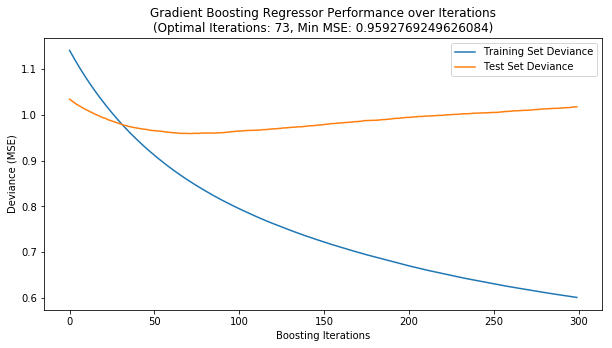

GradientBoosting(n_estimators=73, learning_rate=0.01) -> 0.9592769249626084
[ 79, 10] AUC 0.64237 +/- 0.00174

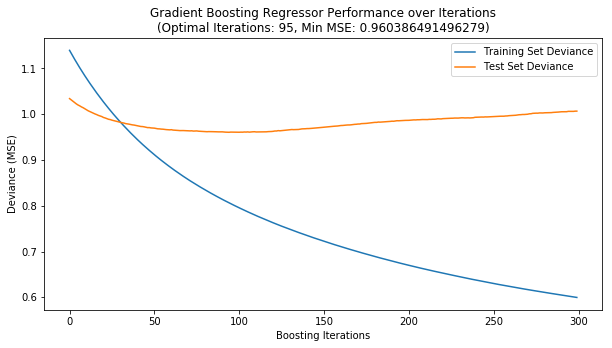

GradientBoosting(n_estimators=95, learning_rate=0.01) -> 0.960386491496279
[ 80, 10] AUC 0.64580 +/- 0.00569

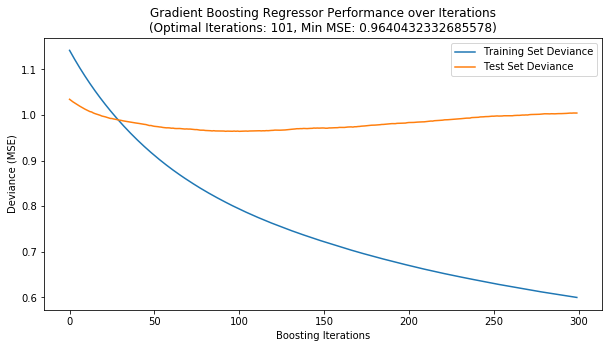

GradientBoosting(n_estimators=101, learning_rate=0.01) -> 0.9640432332685578
[ 81, 10] AUC 0.64386 +/- 0.00236

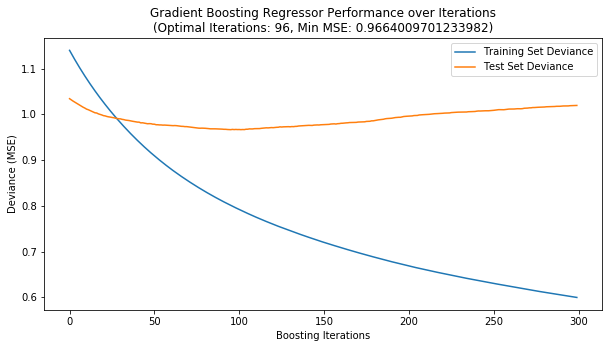

GradientBoosting(n_estimators=96, learning_rate=0.01) -> 0.9664009701233982
[ 82, 10] AUC 0.64556 +/- 0.00461

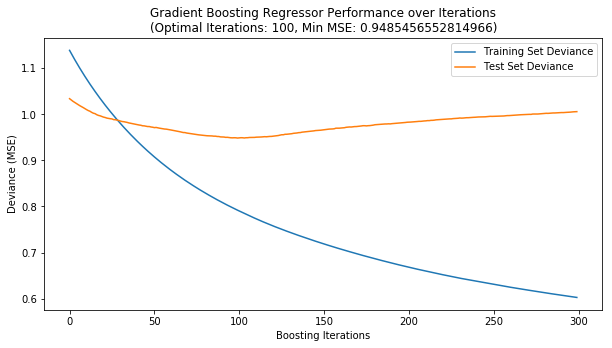

GradientBoosting(n_estimators=100, learning_rate=0.01) -> 0.9485456552814966
[ 83, 10] AUC 0.63449 +/- 0.00434

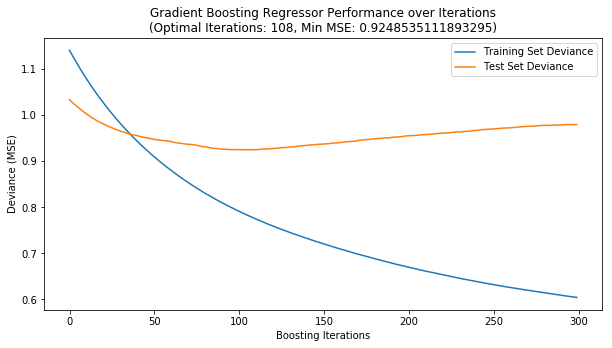

GradientBoosting(n_estimators=108, learning_rate=0.01) -> 0.9248535111893295
[ 84, 10] AUC 0.64801 +/- 0.00483

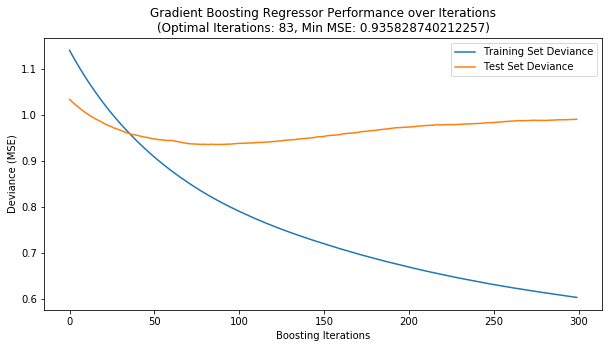

GradientBoosting(n_estimators=83, learning_rate=0.01) -> 0.935828740212257
[ 85, 10] AUC 0.63828 +/- 0.00356

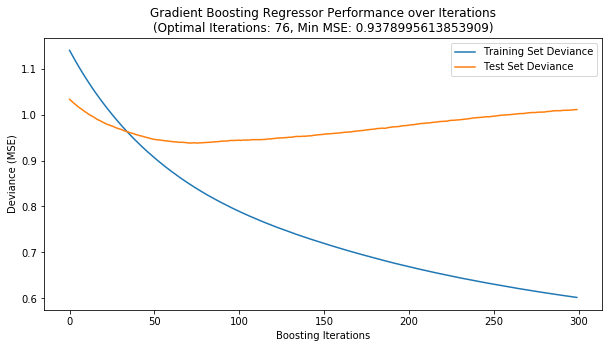

GradientBoosting(n_estimators=76, learning_rate=0.01) -> 0.9378995613853909
[ 86, 10] AUC 0.63335 +/- 0.00279

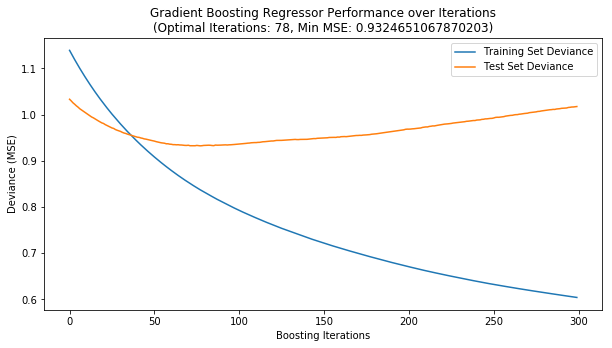

GradientBoosting(n_estimators=78, learning_rate=0.01) -> 0.9324651067870203
[ 87, 10] AUC 0.63574 +/- 0.00463

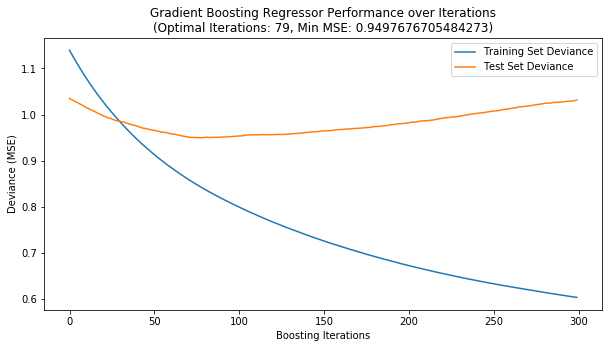

GradientBoosting(n_estimators=79, learning_rate=0.01) -> 0.9497676705484273
[ 88, 10] AUC 0.62704 +/- 0.00485

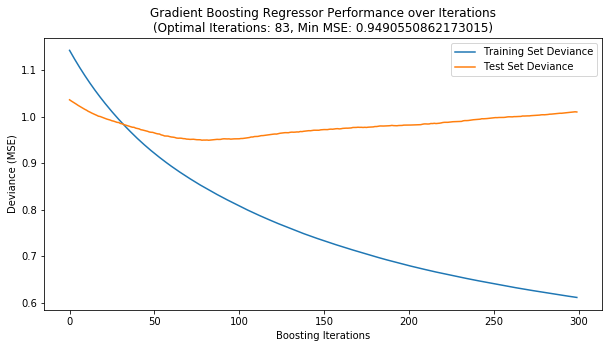

GradientBoosting(n_estimators=83, learning_rate=0.01) -> 0.9490550862173015
[ 89, 10] AUC 0.62206 +/- 0.00290

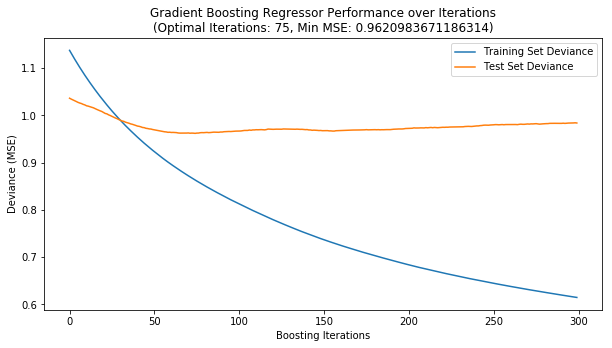

GradientBoosting(n_estimators=75, learning_rate=0.01) -> 0.9620983671186314
[ 90, 10] AUC 0.62376 +/- 0.00306

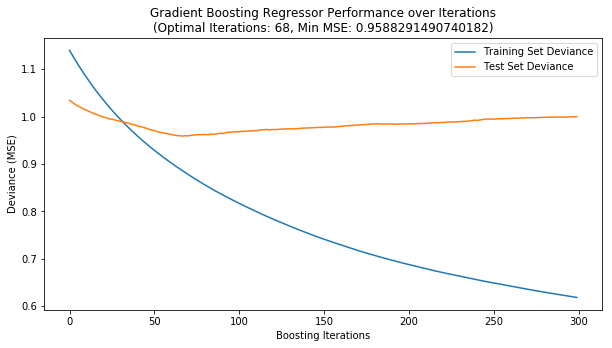

GradientBoosting(n_estimators=68, learning_rate=0.01) -> 0.9588291490740182
[ 91, 10] AUC 0.61713 +/- 0.00304

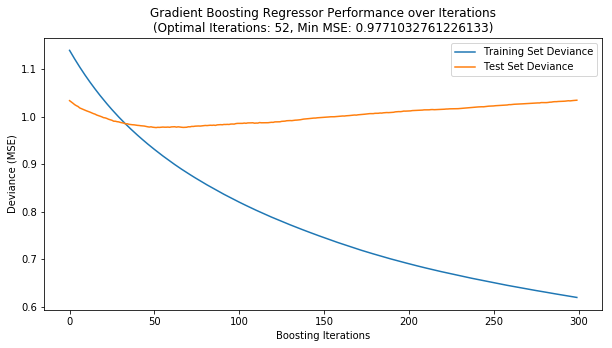

GradientBoosting(n_estimators=52, learning_rate=0.01) -> 0.9771032761226133
[ 92, 10] AUC 0.61101 +/- 0.00455

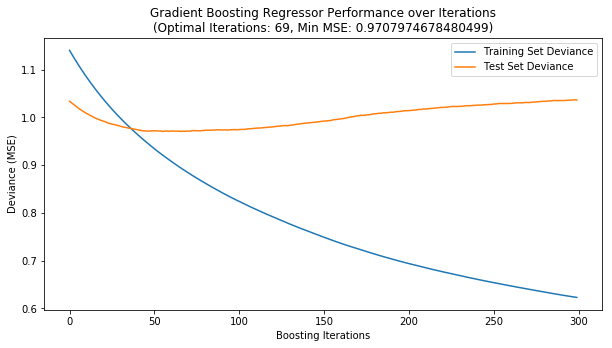

GradientBoosting(n_estimators=69, learning_rate=0.01) -> 0.9707974678480499
[ 93, 10] AUC 0.60118 +/- 0.00455

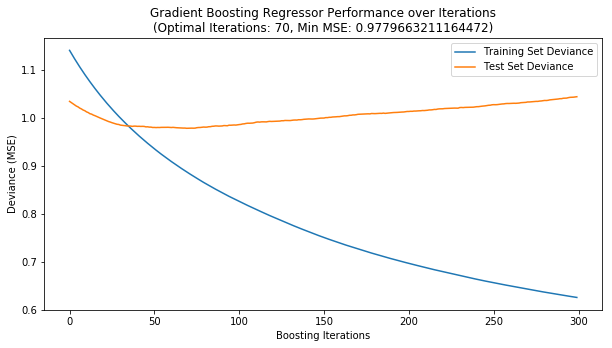

GradientBoosting(n_estimators=70, learning_rate=0.01) -> 0.9779663211164472
[ 94, 10] AUC 0.59278 +/- 0.00360

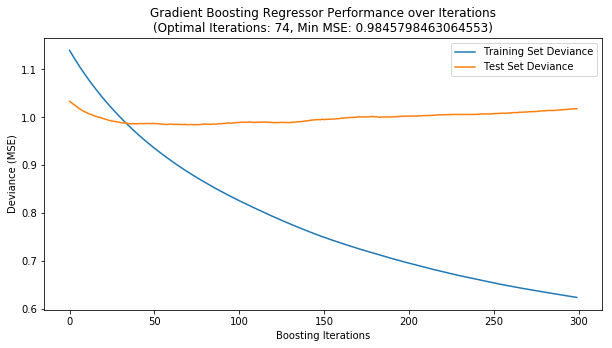

GradientBoosting(n_estimators=74, learning_rate=0.01) -> 0.9845798463064553
[ 95, 10] AUC 0.59398 +/- 0.00291

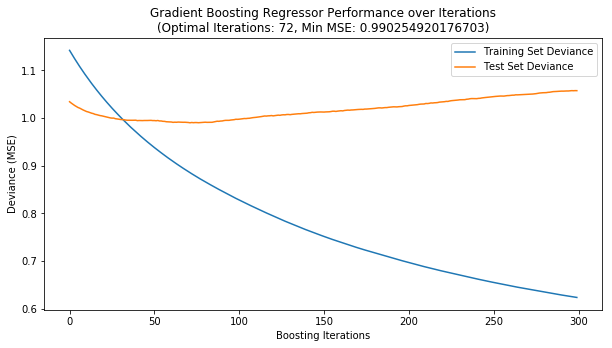

GradientBoosting(n_estimators=72, learning_rate=0.01) -> 0.990254920176703
[ 96, 10] AUC 0.59153 +/- 0.00269

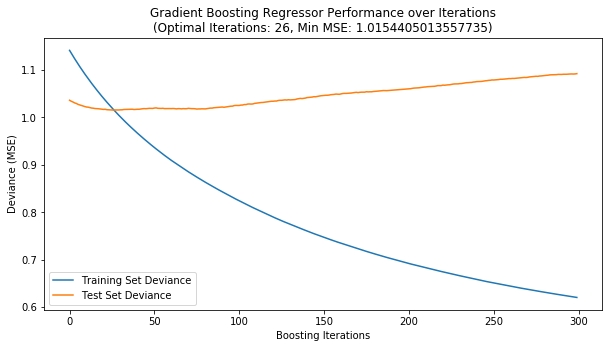

GradientBoosting(n_estimators=26, learning_rate=0.01) -> 1.0154405013557735
[ 97, 10] AUC 0.58484 +/- 0.00601

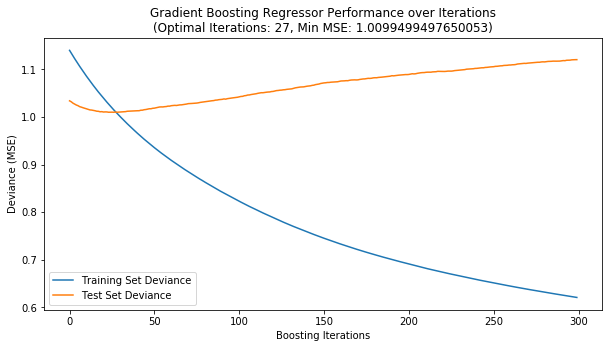

GradientBoosting(n_estimators=27, learning_rate=0.01) -> 1.0099499497650053
[ 98, 10] AUC 0.57041 +/- 0.00710

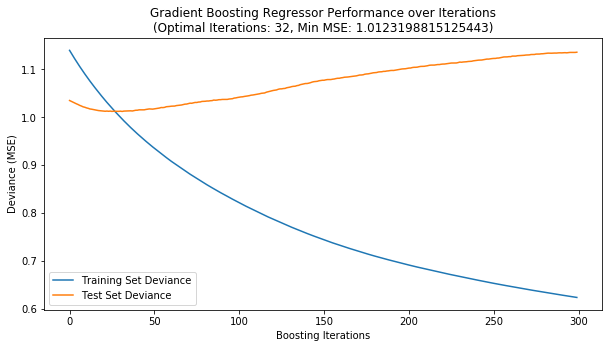

GradientBoosting(n_estimators=32, learning_rate=0.01) -> 1.0123198815125443
[ 99, 10] AUC 0.56769 +/- 0.00796

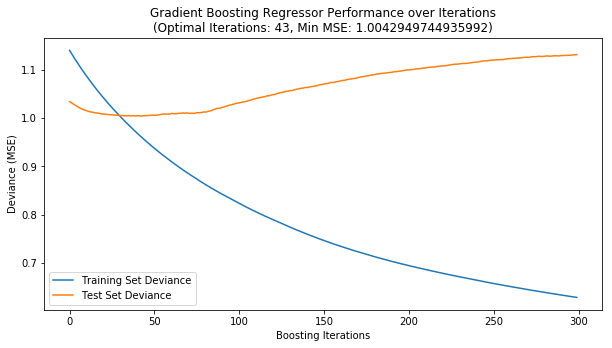

GradientBoosting(n_estimators=43, learning_rate=0.01) -> 1.0042949744935992
[100, 10] AUC 0.56737 +/- 0.00985

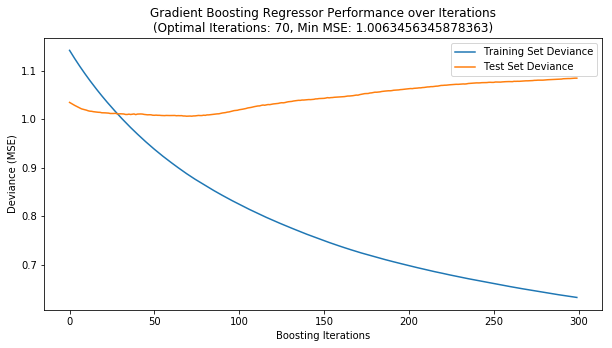

GradientBoosting(n_estimators=70, learning_rate=0.01) -> 1.0063456345878363
[101, 10] AUC 0.58979 +/- 0.00520

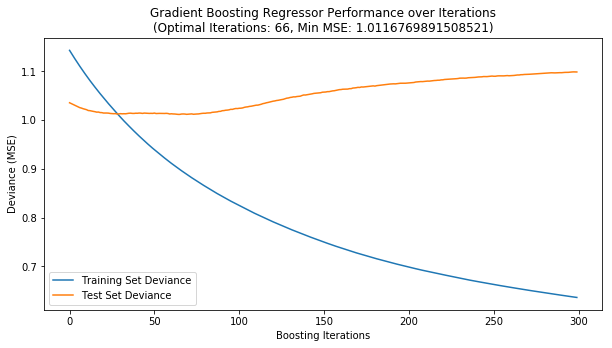

GradientBoosting(n_estimators=66, learning_rate=0.01) -> 1.0116769891508521
[102, 10] AUC 0.58077 +/- 0.00387

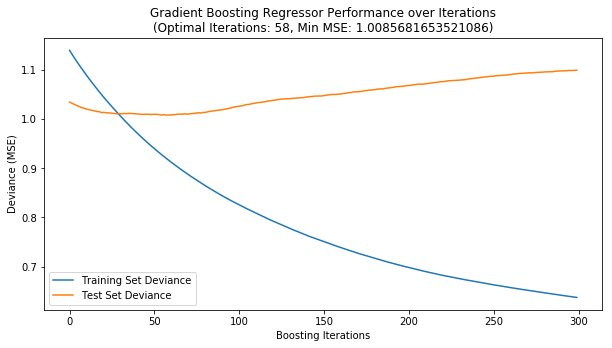

GradientBoosting(n_estimators=58, learning_rate=0.01) -> 1.0085681653521086
[103, 10] AUC 0.57297 +/- 0.00627

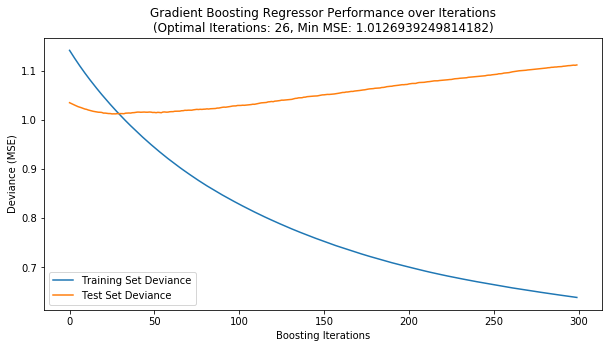

GradientBoosting(n_estimators=26, learning_rate=0.01) -> 1.0126939249814182
[104, 10] AUC 0.57396 +/- 0.01334

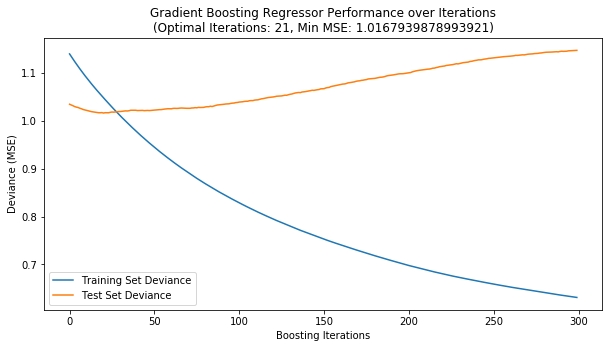

GradientBoosting(n_estimators=21, learning_rate=0.01) -> 1.0167939878993921
[105, 10] AUC 0.58119 +/- 0.01057

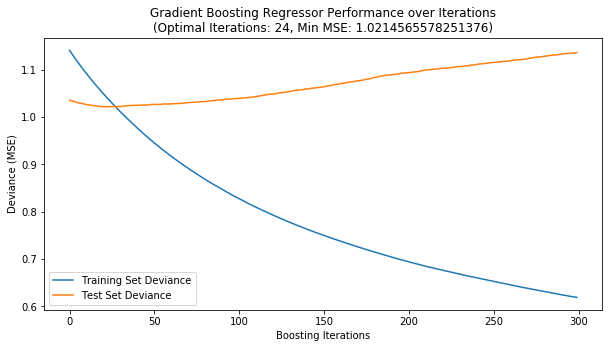

GradientBoosting(n_estimators=24, learning_rate=0.01) -> 1.0214565578251376
[106, 10] AUC 0.54262 +/- 0.00974

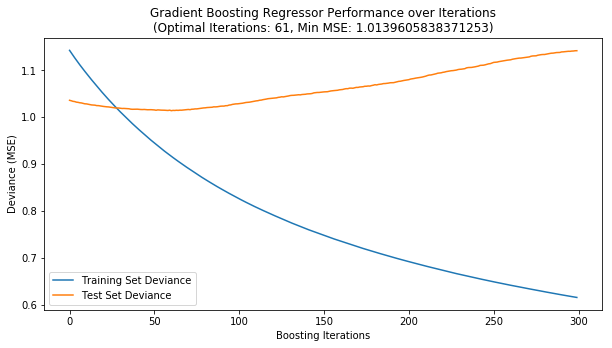

GradientBoosting(n_estimators=61, learning_rate=0.01) -> 1.0139605838371253
[107, 10] AUC 0.57254 +/- 0.00557

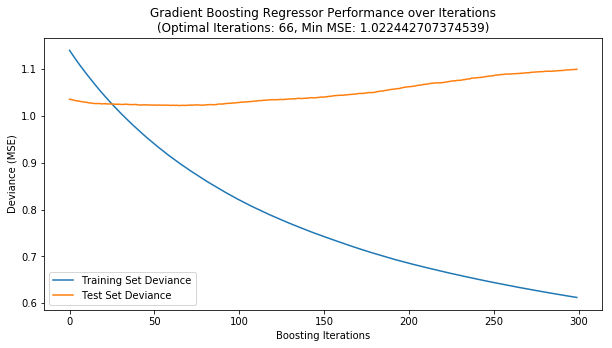

GradientBoosting(n_estimators=66, learning_rate=0.01) -> 1.022442707374539
[108, 10] AUC 0.58666 +/- 0.00403

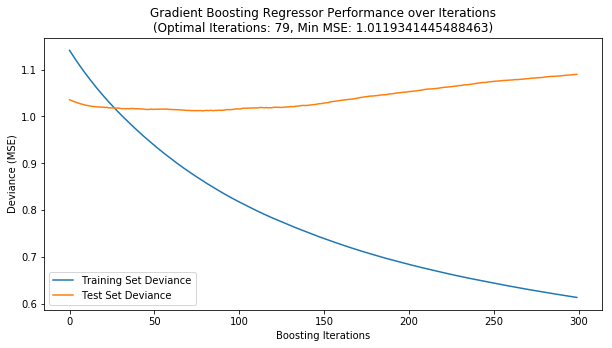

GradientBoosting(n_estimators=79, learning_rate=0.01) -> 1.0119341445488463
[109, 10] AUC 0.59195 +/- 0.00838

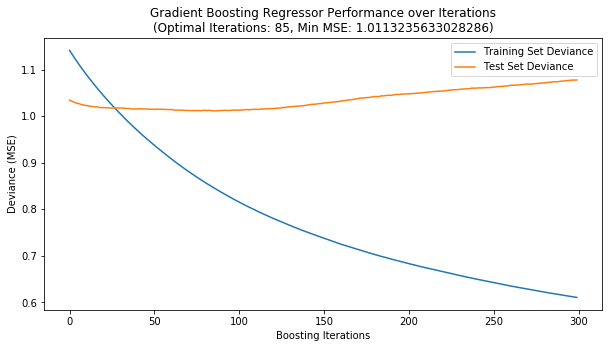

GradientBoosting(n_estimators=85, learning_rate=0.01) -> 1.0113235633028286
[110, 10] AUC 0.59631 +/- 0.00468

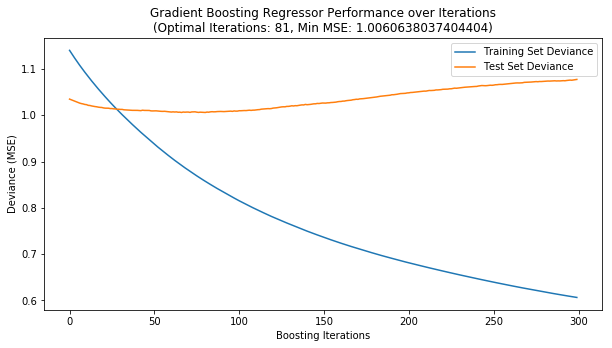

GradientBoosting(n_estimators=81, learning_rate=0.01) -> 1.0060638037404404
[111, 10] AUC 0.57921 +/- 0.00368

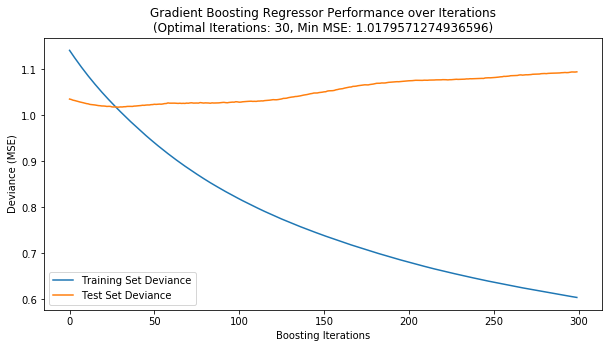

GradientBoosting(n_estimators=30, learning_rate=0.01) -> 1.0179571274936596
[112, 10] AUC 0.55088 +/- 0.00628

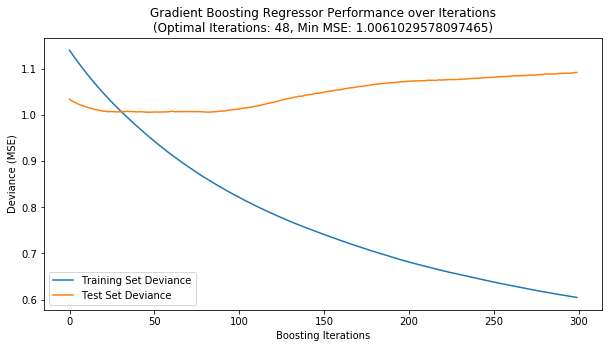

GradientBoosting(n_estimators=48, learning_rate=0.01) -> 1.0061029578097465
[113, 10] AUC 0.57184 +/- 0.00218

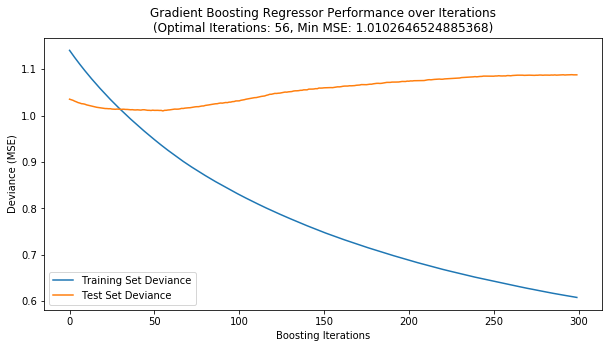

GradientBoosting(n_estimators=56, learning_rate=0.01) -> 1.0102646524885368
[114, 10] AUC 0.57185 +/- 0.00751

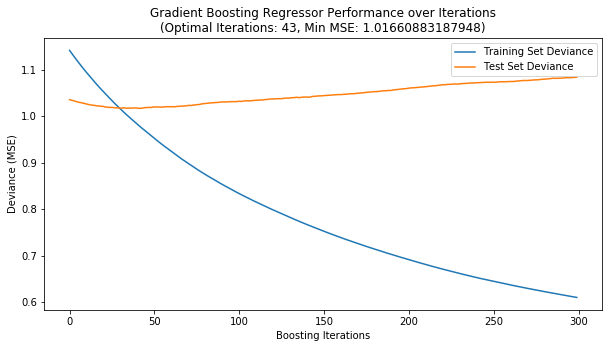

GradientBoosting(n_estimators=43, learning_rate=0.01) -> 1.01660883187948
[115, 10] AUC 0.55979 +/- 0.00957

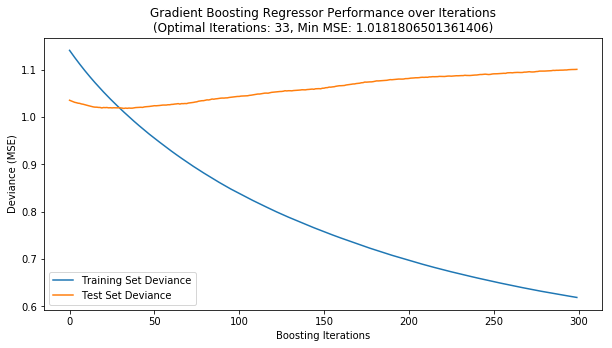

GradientBoosting(n_estimators=33, learning_rate=0.01) -> 1.0181806501361406
[116, 10] AUC 0.57546 +/- 0.00573

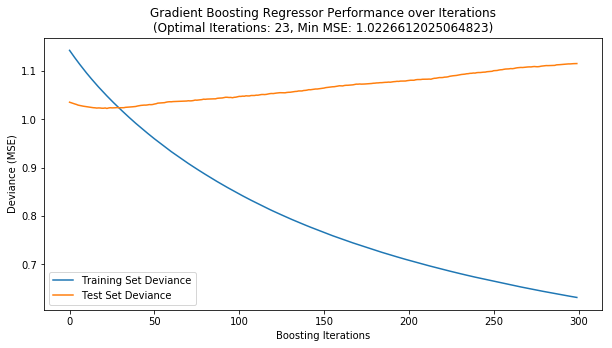

GradientBoosting(n_estimators=23, learning_rate=0.01) -> 1.0226612025064823
[117, 10] AUC 0.54907 +/- 0.00716

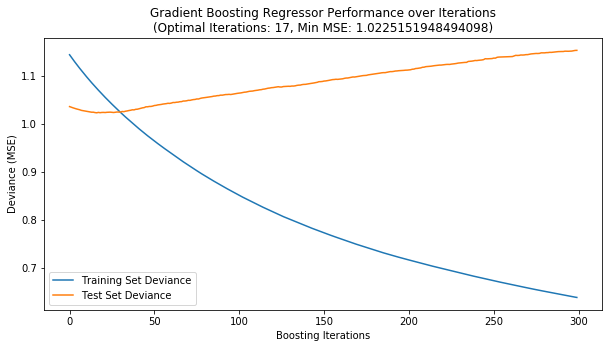

GradientBoosting(n_estimators=17, learning_rate=0.01) -> 1.0225151948494098
[118, 10] AUC 0.54068 +/- 0.01161

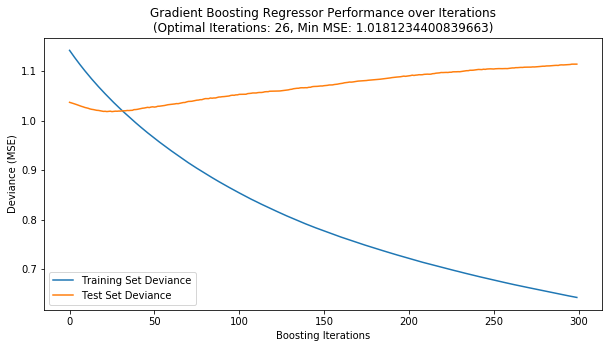

GradientBoosting(n_estimators=26, learning_rate=0.01) -> 1.0181234400839663
[119, 10] AUC 0.51258 +/- 0.01254

In [208]:
LEARNING_RATE = 0.01

auc_lag = []

for lag in range(0, 120):

    aucs = []
    
    # Optimize Regressor
    regressor = GradientBoostingRegressor(n_estimators=int(3/LEARNING_RATE), max_depth=3, learning_rate=LEARNING_RATE)
    n_estimators, mse = train_deviance(regressor, heatwave, precursor_lag=0, lag=lag)
    regressor = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=3, learning_rate=LEARNING_RATE)
    print(f"GradientBoosting(n_estimators={n_estimators}, learning_rate={LEARNING_RATE}) -> {mse}")

    for i in range(10):
        
        predictions = train_all(regressor, heatwave, precursor_lag=0, lag=lag)
        aucs.append(roc_auc_score(heatwave > heatwave_threshold, predictions))
        print(f"\r[{lag:3d}, {i+1:2d}] AUC {np.mean(aucs):5.5f} +/- {np.std(aucs):5.5f}", end="")
        
    auc_lag.append(aucs)

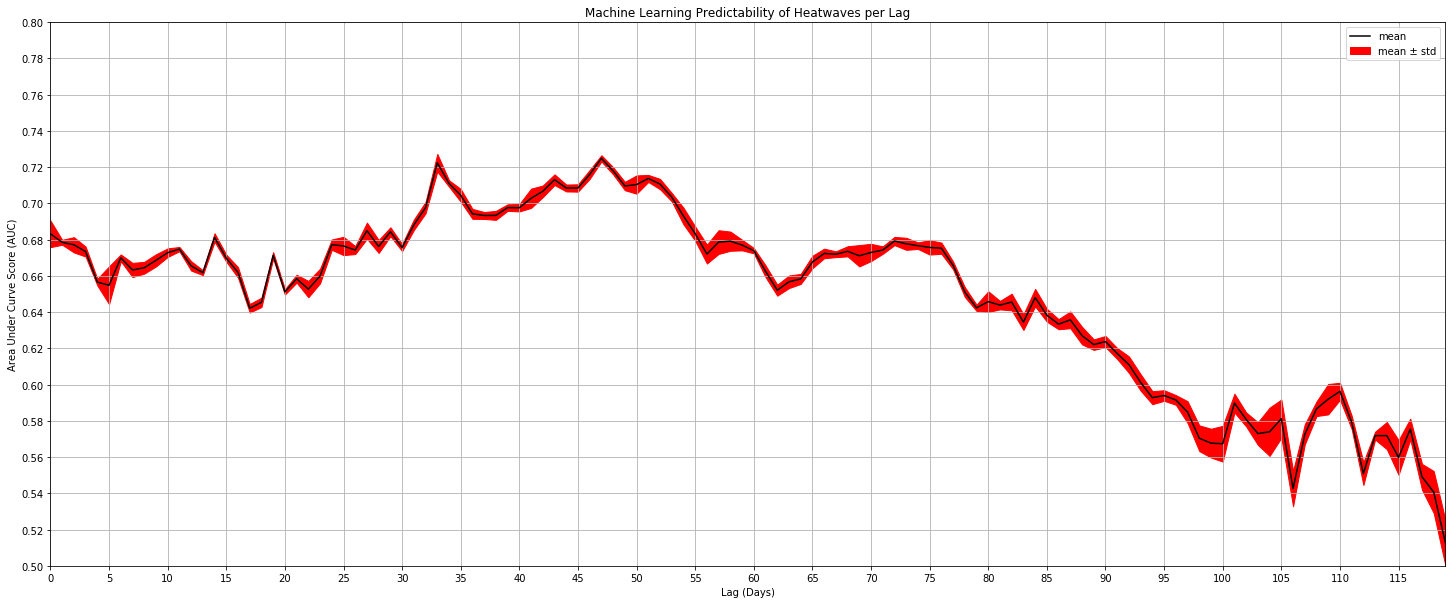

In [267]:
means = np.array([np.mean(auc) for auc in auc_lag])
stds = np.array([np.std(auc) for auc in auc_lag])


plt.rcParams['figure.figsize'] = [25, 10]
plt.title("Machine Learning Predictability of Heatwaves per Lag")
plt.plot(range(0, 120), means, color="black", label="mean")
plt.fill_between(range(0, 120), means-stds, means+stds, color="red", label="mean ± std")

plt.xlim(0, 119)
plt.xticks(range(0, 120, 5))
plt.xlabel("Lag (Days)")

plt.ylim(0.5, 0.8)
plt.yticks(np.linspace(0.5, 0.8, 16))
plt.ylabel("Area Under Curve Score (AUC)")

plt.grid()
plt.legend()

plt.savefig("AUC_LAG_2.png", dpi=300)
plt.show()

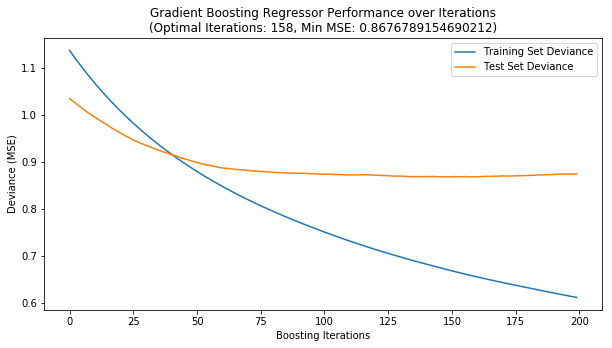

(158, 0.8676789154690212)


In [204]:
## Optimize Gradient Boosting Regressor by Looking at Train/Test Deviance at all Boosting Iterations
regressor = GradientBoostingRegressor(n_estimators=200, max_depth=3, learning_rate=0.01)
print(train_deviance(regressor, heatwave, precursor_lag=0, lag=50))

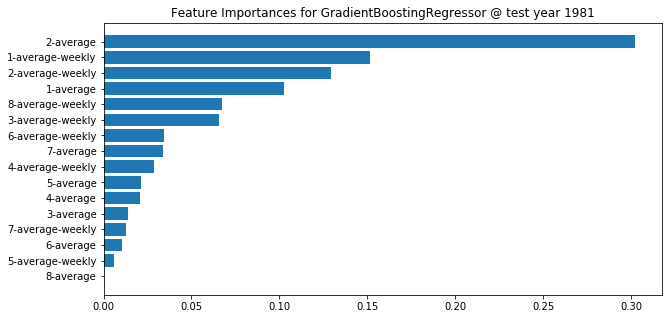

In [177]:
feature_importances(regressor, heatwave, precursor_lag=0, lag=50, test_year=1981)

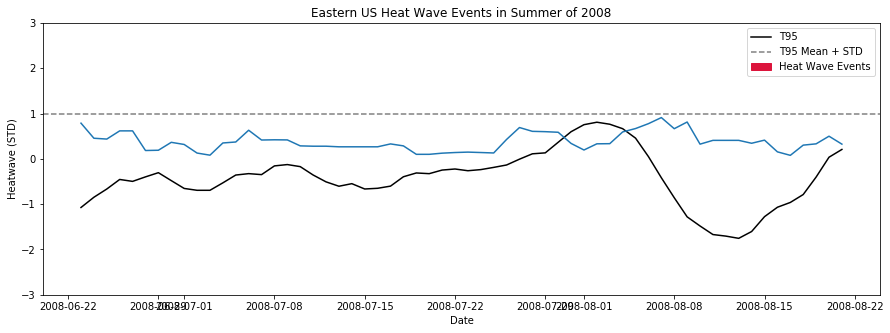

In [157]:
plot_heatwave(heatwave=heatwave['series'], fit=predictions, year=2008)